In [1]:
import copy
import json
import os
import time
import urllib.request
import zipfile
from collections import OrderedDict

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
from torch import nn, optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.autograd import Variable
from torch.utils.data import Dataset

from tqdm.notebook import tqdm

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay,f1_score

In [2]:
class CustomDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        sample, label = self.dataset[idx]

        # We do the tranformation here for training so that each batch will see a slight variation in data
        if self.transform:
            sample = self.transform(sample)
        return sample, label

In [3]:
# Data Augmentations for training set
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])

# Data Augmentations for validation and testing set
test_transforms = transforms.Compose([transforms.Resize((224,224)),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])

In [4]:
train_dataset = datasets.Flowers102(root='./data',
                                    split='train',
                                    download=True)

valid_dataset = datasets.Flowers102(
                                    root='./data',
                                    split='val',
                                    download=True,
                                    transform=test_transforms)

test_dataset = datasets.Flowers102(root='./data',
                                   split='test',
                                   download=True,
                                   transform=test_transforms)

100%|██████████| 344862509/344862509 [00:13<00:00, 25019161.46it/s]


Extracting data/flowers-102/102flowers.tgz to data/flowers-102


100%|██████████| 502/502 [00:00<00:00, 550468.13it/s]


100%|██████████| 14989/14989 [00:00<00:00, 37986962.33it/s]


In [5]:
# Create 2 different training data, one with augmentations and the other without
train_data_with_aug = CustomDataset(train_dataset, train_transforms)
train_data_without_aug = CustomDataset(train_dataset, test_transforms)

test_data = CustomDataset(test_dataset)
valid_data = CustomDataset(valid_dataset)


train_aug_loader = torch.utils.data.DataLoader(
    train_data_with_aug, batch_size=32, shuffle=True)

train_no_aug_loader = torch.utils.data.DataLoader(
    train_data_without_aug, batch_size=32, shuffle=True)

valid_loader = torch.utils.data.DataLoader(
    valid_data, batch_size=32, shuffle=True)

test_loader = torch.utils.data.DataLoader(
            test_data, batch_size=32, shuffle=True)

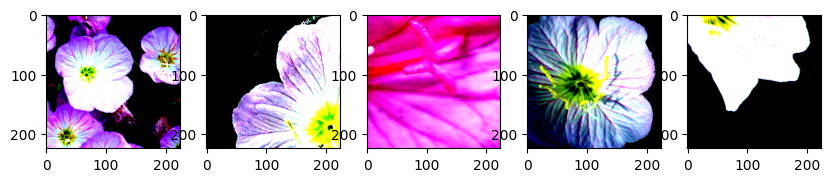

In [6]:
import matplotlib.pyplot as plt

f, ax = plt.subplots(1,5, figsize=(10,8))

for i in range(0, 5):
    ax[i].imshow(train_data_with_aug[i][0].permute(1,2,0))

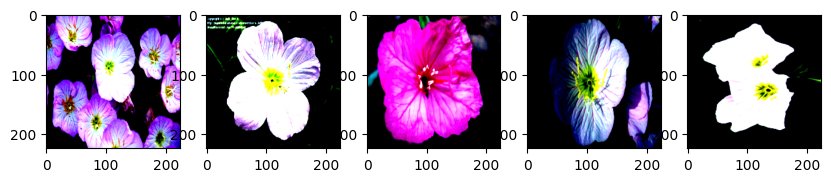

In [7]:
import matplotlib.pyplot as plt

f, ax = plt.subplots(1,5, figsize=(10,8))

for i in range(0, 5):
    ax[i].imshow(train_data_without_aug[i][0].permute(1,2,0))

In [8]:
class CustomMobileNet(nn.Module):
    def __init__(self, num_classes, classification_head='default'):
        super(CustomMobileNet, self).__init__()

        # Load a pre-trained Mobilenet model
        mobilenet = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.DEFAULT)

        # Extract the feature extractor (backbone) from Mobilenet
        self.backbone = mobilenet.features

        # Freeze the Feature Extration
        for param in self.backbone.parameters():
            param.requires_grad = False


        if classification_head == 'default':
            self.classification_head = nn.Sequential(
                nn.AdaptiveAvgPool2d(1),
                nn.Flatten(),
                nn.Dropout(p=0.2, inplace=False),
                nn.Linear(1280, num_classes)
            )
        elif classification_head == 'simple':
            self.classification_head = nn.Sequential(
                nn.AdaptiveAvgPool2d(1),
                nn.Flatten(),
                nn.Linear(1280, num_classes)
            )

        elif classification_head == 'custom':
            self.classification_head = nn.Sequential(
                nn.AdaptiveAvgPool2d(1),
                nn.Flatten(),
                nn.Linear(1280, 2048),      # Add a fully connected layer
                nn.ReLU(),                     # Add ReLU activation
                nn.Dropout(0.3),               # Add dropout for regularization
                nn.Linear(2048, num_classes)    # Final output layer for classification
            )


    def forward(self, x):
        # Forward pass through the backbone
        x = self.backbone(x)

        classification = self.classification_head(x)

        return classification

In [9]:
class EarlyStopper:
    def __init__(self, patience=3, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.max_classification_acc = -np.inf

    def early_stop(self, validation_acc):
        if validation_acc > self.max_classification_acc:
            self.max_classification_acc = validation_acc
            self.counter = 0
        elif validation_acc < (self.max_classification_acc + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [10]:
def train_loop(train_loader, model, loss_fn, optimizer):
    model.train(True)
    running_loss = 0.0
    running_corrects = 0
    for inputs, labels in tqdm(train_loader, desc='train', leave=False):
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward
        # track history if only in train
        with torch.set_grad_enabled(True):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criteria(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        # statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = running_corrects / len(train_loader.dataset)

    return epoch_loss, epoch_acc

# Test function
def test_loop(dataloader, model, loss_fn):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    running_loss, running_corrects = 0, 0

    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc='test', leave=False):
            inputs, labels = inputs.to(device), labels.to(device) # add this line
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            loss = criteria(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(predicted == labels.data)

    test_loss = running_loss / size
    test_correct = running_corrects / size

    return test_loss, test_correct



## Experiment 1: Does doing data augmentation make a difference?

In [11]:
model = CustomMobileNet(102, 'default')

Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-7ebf99e0.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 121MB/s]


In [12]:
criteria = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
early_stopper = EarlyStopper(patience=8, min_delta=0)

In [13]:
epochs=100
device = "cuda" if torch.cuda.is_available() else "mps"
print(device)

cuda


#### With Augmentation

In [14]:
tr_loss, tr_correct = [], []
te_loss, te_correct = [], []
model.to(device)
best_model_wts = copy.deepcopy(model.state_dict())
best_acc = 0.0
for t in tqdm(range(epochs), desc="epochs"):
    train_loss, train_correct = train_loop(train_aug_loader, model, criteria, optimizer)
    test_loss, test_correct = test_loop(valid_loader, model, criteria)

    tr_loss.append(train_loss), tr_correct.append(train_correct)
    te_loss.append(test_loss), te_correct.append(test_correct)
    print(f"Epoch {t+1}: Train_accuracy: {(100*train_correct):>0.2f}%, Train_loss: {train_loss:>8f}, Test_accuracy: {(100*test_correct):>0.2f}%, Test_loss: {test_loss:>8f}")

    if test_correct > best_acc:
        best_acc = test_correct
        best_model_wts = copy.deepcopy(model.state_dict())
        print(f'Best Accuracy currently: {best_acc}')

    if early_stopper.early_stop(test_correct.item()):
        print("Done!")
        break

epochs:   0%|          | 0/100 [00:00<?, ?it/s]

train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 1: Train_accuracy: 5.78%, Train_loss: 4.497962, Test_accuracy: 40.39%, Test_loss: 3.941062
Best Accuracy currently: 0.40392160415649414


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 2: Train_accuracy: 50.00%, Train_loss: 3.618431, Test_accuracy: 59.90%, Test_loss: 3.332746
Best Accuracy currently: 0.5990196466445923


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 3: Train_accuracy: 70.78%, Train_loss: 2.998809, Test_accuracy: 67.45%, Test_loss: 2.849122
Best Accuracy currently: 0.6745098233222961


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 4: Train_accuracy: 75.00%, Train_loss: 2.531849, Test_accuracy: 69.71%, Test_loss: 2.483605
Best Accuracy currently: 0.6970588564872742


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 5: Train_accuracy: 76.27%, Train_loss: 2.195344, Test_accuracy: 72.16%, Test_loss: 2.192480
Best Accuracy currently: 0.7215686440467834


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 6: Train_accuracy: 77.75%, Train_loss: 1.926182, Test_accuracy: 73.53%, Test_loss: 1.996942
Best Accuracy currently: 0.7352941632270813


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 7: Train_accuracy: 81.76%, Train_loss: 1.675240, Test_accuracy: 74.31%, Test_loss: 1.838946
Best Accuracy currently: 0.7431373000144958


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 8: Train_accuracy: 82.45%, Train_loss: 1.501724, Test_accuracy: 76.37%, Test_loss: 1.677760
Best Accuracy currently: 0.7637255191802979


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 9: Train_accuracy: 82.75%, Train_loss: 1.379950, Test_accuracy: 77.84%, Test_loss: 1.538659
Best Accuracy currently: 0.7784314155578613


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 10: Train_accuracy: 85.88%, Train_loss: 1.214457, Test_accuracy: 77.94%, Test_loss: 1.422847
Best Accuracy currently: 0.779411792755127


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 11: Train_accuracy: 85.88%, Train_loss: 1.148641, Test_accuracy: 78.24%, Test_loss: 1.385040
Best Accuracy currently: 0.7823529839515686


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 12: Train_accuracy: 88.14%, Train_loss: 1.055946, Test_accuracy: 77.84%, Test_loss: 1.294361


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 13: Train_accuracy: 87.65%, Train_loss: 0.996559, Test_accuracy: 78.14%, Test_loss: 1.211422


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 14: Train_accuracy: 86.76%, Train_loss: 0.940852, Test_accuracy: 78.92%, Test_loss: 1.192332
Best Accuracy currently: 0.7892157435417175


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 15: Train_accuracy: 88.53%, Train_loss: 0.909197, Test_accuracy: 79.90%, Test_loss: 1.144380
Best Accuracy currently: 0.7990196347236633


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 16: Train_accuracy: 89.12%, Train_loss: 0.821313, Test_accuracy: 80.49%, Test_loss: 1.092265
Best Accuracy currently: 0.8049020171165466


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 17: Train_accuracy: 89.41%, Train_loss: 0.780544, Test_accuracy: 80.49%, Test_loss: 1.062046


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 18: Train_accuracy: 90.00%, Train_loss: 0.747003, Test_accuracy: 80.88%, Test_loss: 1.039895
Best Accuracy currently: 0.8088235855102539


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 19: Train_accuracy: 90.49%, Train_loss: 0.717763, Test_accuracy: 80.59%, Test_loss: 1.001147


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 20: Train_accuracy: 88.73%, Train_loss: 0.720953, Test_accuracy: 80.88%, Test_loss: 0.992780


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 21: Train_accuracy: 89.61%, Train_loss: 0.682920, Test_accuracy: 80.29%, Test_loss: 0.978950


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 22: Train_accuracy: 88.43%, Train_loss: 0.662563, Test_accuracy: 79.80%, Test_loss: 0.970138


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 23: Train_accuracy: 90.29%, Train_loss: 0.637180, Test_accuracy: 81.37%, Test_loss: 0.922828
Best Accuracy currently: 0.8137255311012268


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 24: Train_accuracy: 89.80%, Train_loss: 0.647166, Test_accuracy: 81.08%, Test_loss: 0.905721


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 25: Train_accuracy: 89.71%, Train_loss: 0.613758, Test_accuracy: 81.18%, Test_loss: 0.893244


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 26: Train_accuracy: 91.18%, Train_loss: 0.579501, Test_accuracy: 81.37%, Test_loss: 0.889632


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 27: Train_accuracy: 91.76%, Train_loss: 0.564613, Test_accuracy: 81.37%, Test_loss: 0.857928


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 28: Train_accuracy: 91.47%, Train_loss: 0.534170, Test_accuracy: 80.59%, Test_loss: 0.870317


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 29: Train_accuracy: 92.45%, Train_loss: 0.517809, Test_accuracy: 81.86%, Test_loss: 0.856815
Best Accuracy currently: 0.8186274766921997


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 30: Train_accuracy: 90.98%, Train_loss: 0.576703, Test_accuracy: 81.96%, Test_loss: 0.827223
Best Accuracy currently: 0.8196079134941101


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 31: Train_accuracy: 91.08%, Train_loss: 0.549656, Test_accuracy: 82.06%, Test_loss: 0.820414
Best Accuracy currently: 0.8205882906913757


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 32: Train_accuracy: 92.45%, Train_loss: 0.487642, Test_accuracy: 81.96%, Test_loss: 0.809659


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 33: Train_accuracy: 92.06%, Train_loss: 0.493976, Test_accuracy: 81.47%, Test_loss: 0.806967


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 34: Train_accuracy: 91.76%, Train_loss: 0.475995, Test_accuracy: 81.27%, Test_loss: 0.788920


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 35: Train_accuracy: 92.55%, Train_loss: 0.460655, Test_accuracy: 81.96%, Test_loss: 0.806717


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 36: Train_accuracy: 92.65%, Train_loss: 0.458584, Test_accuracy: 81.67%, Test_loss: 0.782712


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 37: Train_accuracy: 92.25%, Train_loss: 0.470699, Test_accuracy: 82.94%, Test_loss: 0.775678
Best Accuracy currently: 0.8294118046760559


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 38: Train_accuracy: 91.76%, Train_loss: 0.448544, Test_accuracy: 83.04%, Test_loss: 0.769004
Best Accuracy currently: 0.8303921818733215


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 39: Train_accuracy: 92.75%, Train_loss: 0.414721, Test_accuracy: 83.33%, Test_loss: 0.755458
Best Accuracy currently: 0.8333333730697632


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 40: Train_accuracy: 92.16%, Train_loss: 0.438429, Test_accuracy: 81.86%, Test_loss: 0.744600


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 41: Train_accuracy: 93.73%, Train_loss: 0.400381, Test_accuracy: 82.35%, Test_loss: 0.752454


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 42: Train_accuracy: 93.04%, Train_loss: 0.421322, Test_accuracy: 82.84%, Test_loss: 0.743496


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 43: Train_accuracy: 93.04%, Train_loss: 0.420292, Test_accuracy: 82.94%, Test_loss: 0.732425


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 44: Train_accuracy: 91.86%, Train_loss: 0.419961, Test_accuracy: 82.55%, Test_loss: 0.724734


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 45: Train_accuracy: 92.75%, Train_loss: 0.401804, Test_accuracy: 83.04%, Test_loss: 0.735312


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 46: Train_accuracy: 91.37%, Train_loss: 0.425196, Test_accuracy: 81.76%, Test_loss: 0.732116


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 47: Train_accuracy: 93.43%, Train_loss: 0.382537, Test_accuracy: 82.75%, Test_loss: 0.723199
Done!


In [15]:
model.load_state_dict(best_model_wts)

<All keys matched successfully>

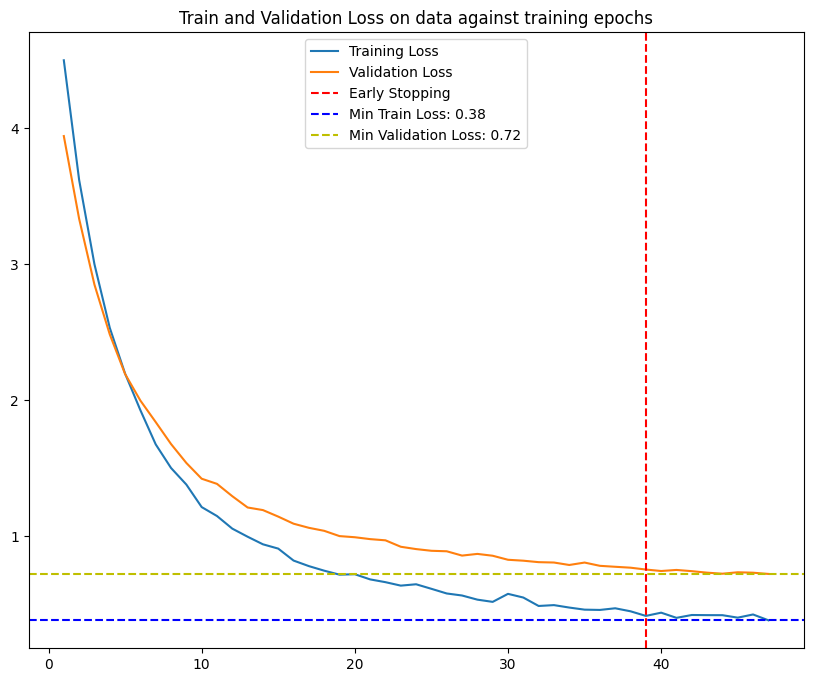

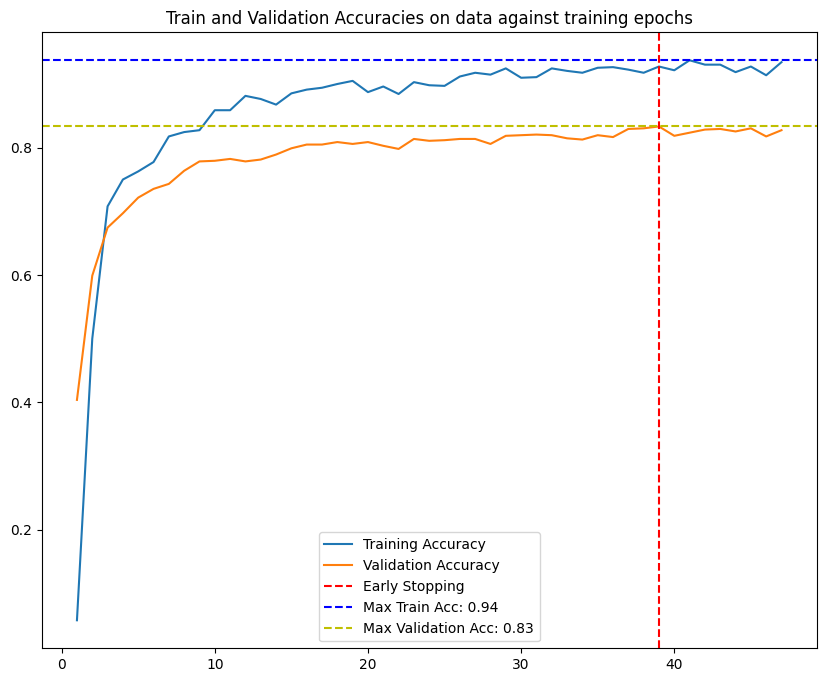

In [16]:
early_stopping_epoch = len(tr_loss)-8
min_train_loss = min(tr_loss)
min_test_loss = min(te_loss)
max_train_accuracy = max(tr_correct).cpu()
max_test_accuracy = max(te_correct).cpu()
tr_correct1 = [i.cpu() for i in tr_correct]
te_correct1 = [i.cpu() for i in te_correct]

fig = plt.figure(figsize=(10,8))
plt.title('Train and Validation Loss on data against training epochs')
plt.plot(range(1,len(tr_loss)+1),tr_loss, label='Training Loss')
plt.plot(range(1,len(te_loss)+1),te_loss,label='Validation Loss')
plt.axvline(x=early_stopping_epoch, color='r', linestyle='--', label='Early Stopping')
plt.axhline(y=min_train_loss, color='b', linestyle='--', label=f'Min Train Loss: {min_train_loss:.2f}')
plt.axhline(y=min_test_loss, color='y', linestyle='--', label=f'Min Validation Loss: {min_test_loss:.2f}')
plt.legend()
plt.show()

fig = plt.figure(figsize=(10,8))
plt.title('Train and Validation Accuracies on data against training epochs')
plt.plot(range(1,len(tr_correct1)+1),tr_correct1, label='Training Accuracy')
plt.plot(range(1,len(te_correct1)+1),te_correct1, label='Validation Accuracy')
plt.axvline(x=early_stopping_epoch, color='r', linestyle='--', label='Early Stopping')
plt.axhline(y=max_train_accuracy, color='b', linestyle='--', label=f'Max Train Acc: {max_train_accuracy:.2f}')
plt.axhline(y=max_test_accuracy, color='y', linestyle='--', label=f'Max Validation Acc: {max_test_accuracy:.2f}')
plt.legend()
plt.show()

In [17]:
correct = 0
total = 0
list_predicted = []
list_labels = []
with torch.no_grad():
    for data in tqdm(test_loader, desc='test'):
        images, labels = data
        images, labels = images.to(device), labels.to(device) # add this line
        outputs = model(images)

        _, predicted = torch.max(outputs.data, 1)
        predicted, labels = predicted.cpu(), labels.cpu()
        list_predicted.extend(predicted)
        list_labels.extend(labels)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print('Accuracy on test images: ', 100*(correct/total), '%')

aug_f1 = f1_score(list_labels, list_predicted, average='weighted')
aug_acc = 100*(correct/total)

test:   0%|          | 0/193 [00:00<?, ?it/s]

Accuracy on test images:  81.28150918848593 %


In [18]:
print(classification_report(list_labels, list_predicted))

              precision    recall  f1-score   support

           0       0.35      0.80      0.48        20
           1       0.94      0.78      0.85        40
           2       0.35      0.35      0.35        20
           3       0.51      0.50      0.51        36
           4       0.82      0.62      0.71        45
           5       0.92      0.92      0.92        25
           6       0.53      0.90      0.67        20
           7       0.98      1.00      0.99        65
           8       0.92      0.85      0.88        26
           9       1.00      0.88      0.94        25
          10       0.71      0.54      0.61        67
          11       1.00      0.64      0.78        67
          12       0.83      1.00      0.91        29
          13       0.80      1.00      0.89        28
          14       0.69      0.93      0.79        29
          15       0.72      0.86      0.78        21
          16       1.00      0.85      0.92        65
          17       0.83    

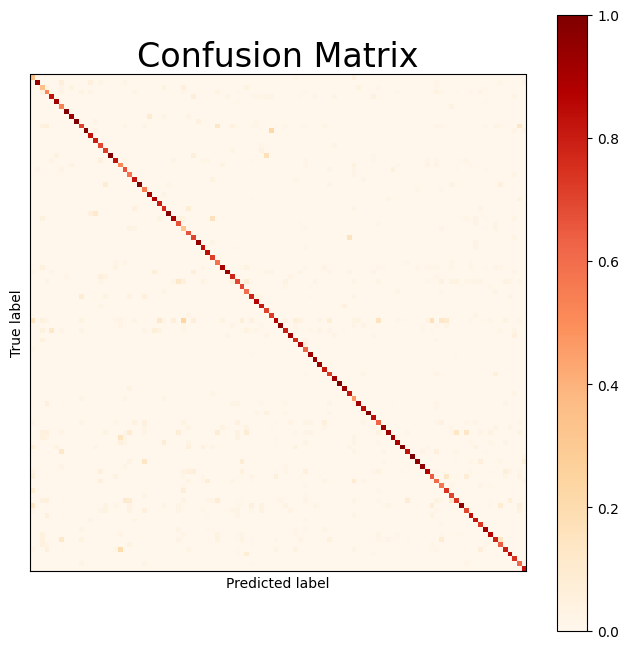

In [19]:
c_m = confusion_matrix(list_labels, list_predicted, normalize='pred')

plt.rcParams['figure.figsize'] = (8, 8)
display_c_m = ConfusionMatrixDisplay(c_m)
display_c_m.plot(cmap='OrRd', include_values=False)

plt.title('Confusion Matrix', fontsize=24)

plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
# Showing the plot
plt.show()

#### Without Augmentation

In [20]:
model = CustomMobileNet(102, 'default')

In [21]:
criteria = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
early_stopper = EarlyStopper(patience=8, min_delta=0)

In [22]:
tr_loss, tr_correct = [], []
te_loss, te_correct = [], []
model.to(device)
best_model_wts = copy.deepcopy(model.state_dict())
best_acc = 0.0
for t in tqdm(range(epochs), desc="epochs"):
    train_loss, train_correct = train_loop(train_no_aug_loader, model, criteria, optimizer)
    test_loss, test_correct = test_loop(valid_loader, model, criteria)

    tr_loss.append(train_loss), tr_correct.append(train_correct)
    te_loss.append(test_loss), te_correct.append(test_correct)
    print(f"Epoch {t+1}: Train_accuracy: {(100*train_correct):>0.2f}%, Train_loss: {train_loss:>8f}, Test_accuracy: {(100*test_correct):>0.2f}%, Test_loss: {test_loss:>8f}")

    if test_correct > best_acc:
        best_acc = test_correct
        best_model_wts = copy.deepcopy(model.state_dict())
        print(f'Best Accuracy currently: {best_acc}')

    if early_stopper.early_stop(test_correct.item()):
        print("Done!")
        break

epochs:   0%|          | 0/100 [00:00<?, ?it/s]

train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 1: Train_accuracy: 10.98%, Train_loss: 4.423601, Test_accuracy: 51.37%, Test_loss: 3.812244
Best Accuracy currently: 0.5137255191802979


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 2: Train_accuracy: 76.18%, Train_loss: 3.193186, Test_accuracy: 68.82%, Test_loss: 3.072869
Best Accuracy currently: 0.688235342502594


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 3: Train_accuracy: 92.06%, Train_loss: 2.316776, Test_accuracy: 74.02%, Test_loss: 2.494343
Best Accuracy currently: 0.7401961088180542


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 4: Train_accuracy: 95.49%, Train_loss: 1.684242, Test_accuracy: 78.14%, Test_loss: 2.090907
Best Accuracy currently: 0.781372606754303


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 5: Train_accuracy: 98.14%, Train_loss: 1.228173, Test_accuracy: 78.53%, Test_loss: 1.821554
Best Accuracy currently: 0.7852941751480103


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 6: Train_accuracy: 98.24%, Train_loss: 0.946448, Test_accuracy: 79.41%, Test_loss: 1.613549
Best Accuracy currently: 0.7941176891326904


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 7: Train_accuracy: 99.22%, Train_loss: 0.715184, Test_accuracy: 80.39%, Test_loss: 1.476923
Best Accuracy currently: 0.803921639919281


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 8: Train_accuracy: 99.41%, Train_loss: 0.588501, Test_accuracy: 80.69%, Test_loss: 1.369326
Best Accuracy currently: 0.8068627715110779


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 9: Train_accuracy: 99.51%, Train_loss: 0.466165, Test_accuracy: 80.69%, Test_loss: 1.282675


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 10: Train_accuracy: 99.90%, Train_loss: 0.393756, Test_accuracy: 81.37%, Test_loss: 1.205559
Best Accuracy currently: 0.8137255311012268


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 11: Train_accuracy: 99.80%, Train_loss: 0.332321, Test_accuracy: 81.76%, Test_loss: 1.166229
Best Accuracy currently: 0.8176470994949341


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 12: Train_accuracy: 100.00%, Train_loss: 0.285397, Test_accuracy: 81.57%, Test_loss: 1.107163


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 13: Train_accuracy: 99.90%, Train_loss: 0.252206, Test_accuracy: 82.45%, Test_loss: 1.070173
Best Accuracy currently: 0.824509859085083


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 14: Train_accuracy: 100.00%, Train_loss: 0.213817, Test_accuracy: 82.35%, Test_loss: 1.052067


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 15: Train_accuracy: 100.00%, Train_loss: 0.190783, Test_accuracy: 82.45%, Test_loss: 1.022294


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 16: Train_accuracy: 100.00%, Train_loss: 0.164583, Test_accuracy: 82.75%, Test_loss: 0.984913
Best Accuracy currently: 0.8274510502815247


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 17: Train_accuracy: 100.00%, Train_loss: 0.155719, Test_accuracy: 82.84%, Test_loss: 0.979624
Best Accuracy currently: 0.8284314274787903


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 18: Train_accuracy: 100.00%, Train_loss: 0.134561, Test_accuracy: 82.25%, Test_loss: 0.952272


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 19: Train_accuracy: 100.00%, Train_loss: 0.117603, Test_accuracy: 82.25%, Test_loss: 0.941736


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 20: Train_accuracy: 100.00%, Train_loss: 0.110543, Test_accuracy: 82.16%, Test_loss: 0.928825


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 21: Train_accuracy: 100.00%, Train_loss: 0.108538, Test_accuracy: 83.24%, Test_loss: 0.910147
Best Accuracy currently: 0.8323529958724976


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 22: Train_accuracy: 100.00%, Train_loss: 0.095115, Test_accuracy: 82.45%, Test_loss: 0.890098


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 23: Train_accuracy: 100.00%, Train_loss: 0.087333, Test_accuracy: 83.24%, Test_loss: 0.875586


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 24: Train_accuracy: 100.00%, Train_loss: 0.083086, Test_accuracy: 82.55%, Test_loss: 0.873082


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 25: Train_accuracy: 100.00%, Train_loss: 0.080982, Test_accuracy: 83.14%, Test_loss: 0.858183


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 26: Train_accuracy: 100.00%, Train_loss: 0.078603, Test_accuracy: 82.84%, Test_loss: 0.854045


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 27: Train_accuracy: 100.00%, Train_loss: 0.069524, Test_accuracy: 82.55%, Test_loss: 0.855093


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 28: Train_accuracy: 100.00%, Train_loss: 0.062280, Test_accuracy: 82.65%, Test_loss: 0.840916


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 29: Train_accuracy: 100.00%, Train_loss: 0.059340, Test_accuracy: 82.84%, Test_loss: 0.816236


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 30: Train_accuracy: 100.00%, Train_loss: 0.055951, Test_accuracy: 82.35%, Test_loss: 0.817864
Done!


In [23]:
model.load_state_dict(best_model_wts)

<All keys matched successfully>

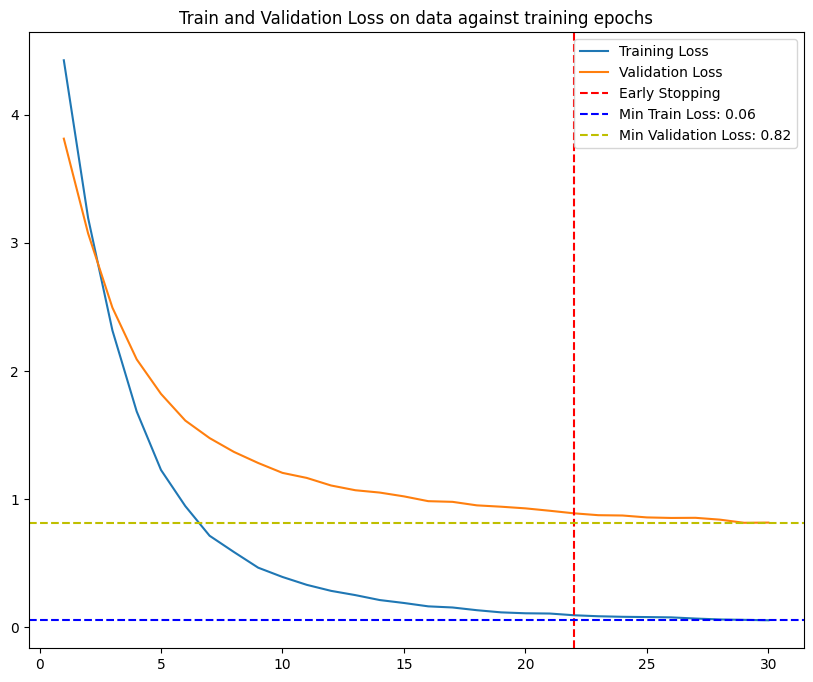

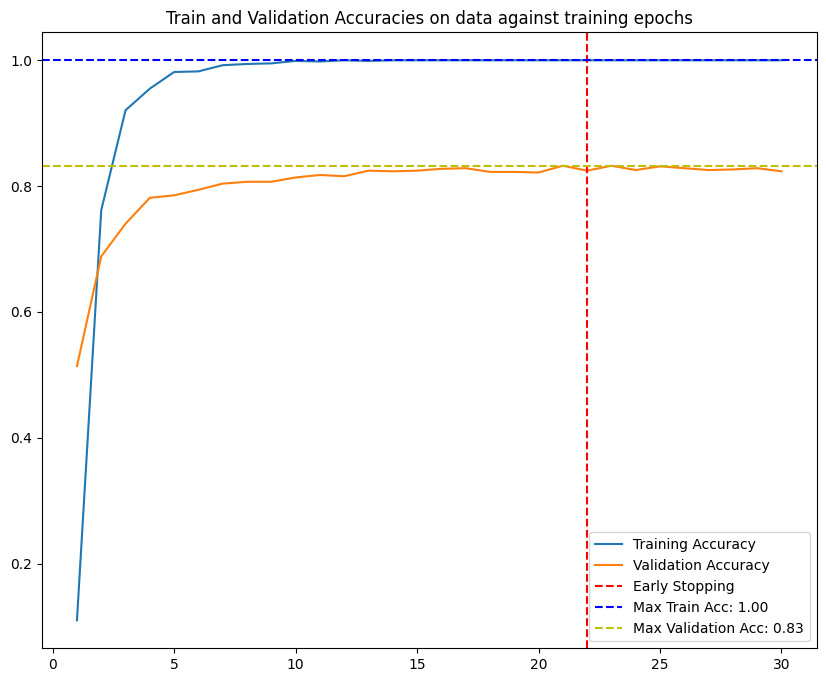

In [24]:
early_stopping_epoch = len(tr_loss)-8
min_train_loss = min(tr_loss)
min_test_loss = min(te_loss)
max_train_accuracy = max(tr_correct).cpu()
max_test_accuracy = max(te_correct).cpu()
tr_correct1 = [i.cpu() for i in tr_correct]
te_correct1 = [i.cpu() for i in te_correct]

fig = plt.figure(figsize=(10,8))
plt.title('Train and Validation Loss on data against training epochs')
plt.plot(range(1,len(tr_loss)+1),tr_loss, label='Training Loss')
plt.plot(range(1,len(te_loss)+1),te_loss,label='Validation Loss')
plt.axvline(x=early_stopping_epoch, color='r', linestyle='--', label='Early Stopping')
plt.axhline(y=min_train_loss, color='b', linestyle='--', label=f'Min Train Loss: {min_train_loss:.2f}')
plt.axhline(y=min_test_loss, color='y', linestyle='--', label=f'Min Validation Loss: {min_test_loss:.2f}')
plt.legend()
plt.show()

fig = plt.figure(figsize=(10,8))
plt.title('Train and Validation Accuracies on data against training epochs')
plt.plot(range(1,len(tr_correct1)+1),tr_correct1, label='Training Accuracy')
plt.plot(range(1,len(te_correct1)+1),te_correct1, label='Validation Accuracy')
plt.axvline(x=early_stopping_epoch, color='r', linestyle='--', label='Early Stopping')
plt.axhline(y=max_train_accuracy, color='b', linestyle='--', label=f'Max Train Acc: {max_train_accuracy:.2f}')
plt.axhline(y=max_test_accuracy, color='y', linestyle='--', label=f'Max Validation Acc: {max_test_accuracy:.2f}')
plt.legend()
plt.show()

In [25]:
correct = 0
total = 0
list_predicted = []
list_labels = []
with torch.no_grad():
    for data in tqdm(test_loader, desc='test'):
        images, labels = data
        images, labels = images.to(device), labels.to(device) # add this line
        outputs = model(images)

        _, predicted = torch.max(outputs.data, 1)
        predicted, labels = predicted.cpu(), labels.cpu()
        list_predicted.extend(predicted)
        list_labels.extend(labels)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print('Accuracy on test images: ', 100*(correct/total), '%')

no_aug_f1 = f1_score(list_predicted, list_labels, average='weighted')
no_aug_acc = 100*(correct/total)

test:   0%|          | 0/193 [00:00<?, ?it/s]

Accuracy on test images:  81.5579769068141 %


In [26]:
print(classification_report(list_labels, list_predicted))

              precision    recall  f1-score   support

           0       0.35      0.60      0.44        20
           1       0.97      0.95      0.96        40
           2       0.19      0.45      0.27        20
           3       0.55      0.61      0.58        36
           4       0.86      0.80      0.83        45
           5       0.83      0.96      0.89        25
           6       0.76      0.80      0.78        20
           7       0.93      0.98      0.96        65
           8       0.70      0.81      0.75        26
           9       0.92      0.96      0.94        25
          10       0.62      0.60      0.61        67
          11       0.90      0.91      0.90        67
          12       0.87      0.93      0.90        29
          13       0.72      1.00      0.84        28
          14       0.72      0.97      0.82        29
          15       0.75      0.86      0.80        21
          16       0.95      0.91      0.93        65
          17       0.69    

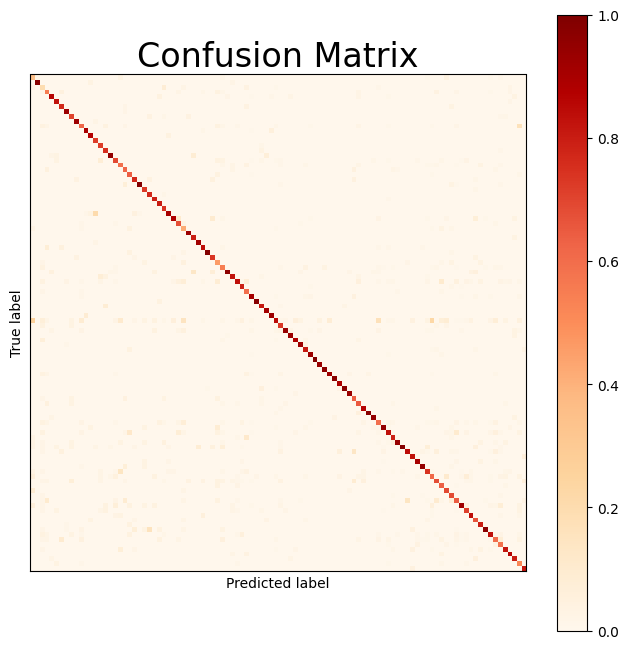

In [27]:
c_m = confusion_matrix(list_labels, list_predicted, normalize='pred')

plt.rcParams['figure.figsize'] = (8, 8)
display_c_m = ConfusionMatrixDisplay(c_m)
display_c_m.plot(cmap='OrRd', include_values=False)

plt.title('Confusion Matrix', fontsize=24)

plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
# Showing the plot
plt.show()

In [28]:
print(f"""
Accuracy with augmentation: {aug_acc}%
F1 with augmentation {aug_f1}
Accuracy w/o augmentation: {no_aug_acc}%
F1 without augmentation {no_aug_f1}
""")


Accuracy with augmentation: 81.28150918848593%
F1 with augmentation 0.8114039187153751
Accuracy w/o augmentation: 81.5579769068141%
F1 without augmentation 0.8157798965556549



#### Conclusion on Augmentation

Augmentation does help to improve the overall accuracy and to mitigate the model from overfitting.

### Experiment 2: Inclusion of MixUp Augmentation

In [29]:
def mixup_data(x, y, alpha=1.0, use_cuda=True):
    '''Compute the mixup data. Return mixed inputs, pairs of targets, and lambda
      - https://github.com/hongyi-zhang/mixup
    '''
    if alpha > 0.:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1.
    batch_size = x.size()[0]
    if use_cuda:
        index = torch.randperm(batch_size).cuda()
    else:
        index = torch.randperm(batch_size)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]

    return mixed_x, y_a, y_b, lam

def mixup_criterion(y_a, y_b, lam):
    '''
    - Mixup criterion
    - https://github.com/hongyi-zhang/mixup
    '''
    return lambda criterion, pred: lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

mixup = True

##### Mixup

In [30]:
model = CustomMobileNet(102, 'default')

In [31]:
criteria = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
early_stopper = EarlyStopper(patience=8, min_delta=0)

In [32]:
def train_loop_mixup(train_loader, net, optimizer, alpha):
    if device=='cuda':
        use_cuda=True
    else:
        use_cuda=False
    net.train()
    train_loss = 0
    correct = 0
    total = 0

    for batch_idx, (inputs, targets) in enumerate(tqdm(train_loader, desc='train', leave=False)):
        if use_cuda:
            inputs, targets = inputs.cuda(), targets.cuda()
        optimizer.zero_grad()

        # generate mixed inputs, two one-hot label vectors and mixing coefficient
        inputs, targets_a, targets_b, lam = mixup_data(inputs, targets, alpha, use_cuda)
        inputs, targets_a, targets_b = Variable(inputs), Variable(targets_a), Variable(targets_b)
        outputs = net(inputs)
        loss_func = mixup_criterion(targets_a, targets_b, lam)
        loss = loss_func(criteria, outputs)

        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += lam * predicted.eq(targets_a.data).cpu().sum() + (1 - lam) * predicted.eq(targets_b.data).cpu().sum()
    return (train_loss/batch_idx, 100.*correct/total)


tr_loss, tr_correct = [], []
te_loss, te_correct = [], []
model.to(device)
best_model_wts = copy.deepcopy(model.state_dict())
best_acc = 0.0
for t in range(epochs):
    train_loss, train_correct = train_loop_mixup(train_aug_loader, model, optimizer, 0.2)
    test_loss, test_correct = test_loop(valid_loader, model, criteria)

    tr_loss.append(train_loss), tr_correct.append(train_correct)
    te_loss.append(test_loss), te_correct.append(test_correct)
    print(f"Epoch {t+1}: Train_accuracy: {(train_correct):>0.2f}%, Train_loss: {train_loss:>8f}, Test_accuracy: {(100*test_correct):>0.2f}%, Test_loss: {test_loss:>8f}")

    if test_correct > best_acc:
        best_acc = test_correct
        best_model_wts = copy.deepcopy(model.state_dict())
        print(f'Best Accuracy currently: {best_acc}')

    if early_stopper.early_stop(test_correct.item()):
        print("Done!")
        break

train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 1: Train_accuracy: 5.61%, Train_loss: 4.708111, Test_accuracy: 36.18%, Test_loss: 4.051892
Best Accuracy currently: 0.36176472902297974


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 2: Train_accuracy: 37.29%, Train_loss: 4.003592, Test_accuracy: 57.35%, Test_loss: 3.518639
Best Accuracy currently: 0.5735294222831726


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 3: Train_accuracy: 50.35%, Train_loss: 3.520783, Test_accuracy: 61.76%, Test_loss: 3.139628
Best Accuracy currently: 0.617647111415863


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 4: Train_accuracy: 61.53%, Train_loss: 3.084549, Test_accuracy: 66.76%, Test_loss: 2.748933
Best Accuracy currently: 0.667647123336792


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 5: Train_accuracy: 62.87%, Train_loss: 2.830111, Test_accuracy: 69.22%, Test_loss: 2.468637
Best Accuracy currently: 0.6921569108963013


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 6: Train_accuracy: 65.93%, Train_loss: 2.599006, Test_accuracy: 70.39%, Test_loss: 2.287599
Best Accuracy currently: 0.7039216160774231


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 7: Train_accuracy: 63.84%, Train_loss: 2.512529, Test_accuracy: 71.27%, Test_loss: 2.153114
Best Accuracy currently: 0.7127451300621033


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 8: Train_accuracy: 72.48%, Train_loss: 2.111077, Test_accuracy: 73.82%, Test_loss: 1.913094
Best Accuracy currently: 0.738235354423523


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 9: Train_accuracy: 67.37%, Train_loss: 2.218442, Test_accuracy: 73.92%, Test_loss: 1.955837
Best Accuracy currently: 0.7392157316207886


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 10: Train_accuracy: 70.88%, Train_loss: 2.046062, Test_accuracy: 74.61%, Test_loss: 1.761856
Best Accuracy currently: 0.7460784912109375


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 11: Train_accuracy: 73.21%, Train_loss: 1.900106, Test_accuracy: 74.51%, Test_loss: 1.679655


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 12: Train_accuracy: 74.37%, Train_loss: 1.779956, Test_accuracy: 76.47%, Test_loss: 1.572632
Best Accuracy currently: 0.7647059559822083


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 13: Train_accuracy: 72.45%, Train_loss: 1.827134, Test_accuracy: 76.37%, Test_loss: 1.513755


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 14: Train_accuracy: 69.45%, Train_loss: 1.890531, Test_accuracy: 77.55%, Test_loss: 1.485363
Best Accuracy currently: 0.7754902243614197


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 15: Train_accuracy: 81.48%, Train_loss: 1.384659, Test_accuracy: 78.43%, Test_loss: 1.326683
Best Accuracy currently: 0.7843137979507446


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 16: Train_accuracy: 69.43%, Train_loss: 1.879871, Test_accuracy: 77.75%, Test_loss: 1.392013


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 17: Train_accuracy: 76.40%, Train_loss: 1.527349, Test_accuracy: 77.45%, Test_loss: 1.331297


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 18: Train_accuracy: 81.17%, Train_loss: 1.317439, Test_accuracy: 79.22%, Test_loss: 1.199203
Best Accuracy currently: 0.7921569347381592


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 19: Train_accuracy: 72.16%, Train_loss: 1.769917, Test_accuracy: 79.12%, Test_loss: 1.289072


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 20: Train_accuracy: 77.71%, Train_loss: 1.403304, Test_accuracy: 80.29%, Test_loss: 1.206492
Best Accuracy currently: 0.8029412031173706


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 21: Train_accuracy: 77.22%, Train_loss: 1.452290, Test_accuracy: 79.61%, Test_loss: 1.206878


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 22: Train_accuracy: 80.46%, Train_loss: 1.354207, Test_accuracy: 79.61%, Test_loss: 1.180999


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 23: Train_accuracy: 77.60%, Train_loss: 1.464100, Test_accuracy: 79.41%, Test_loss: 1.150210


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 24: Train_accuracy: 72.16%, Train_loss: 1.645170, Test_accuracy: 79.71%, Test_loss: 1.120928


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 25: Train_accuracy: 75.37%, Train_loss: 1.477877, Test_accuracy: 79.71%, Test_loss: 1.104672


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 26: Train_accuracy: 71.69%, Train_loss: 1.679398, Test_accuracy: 79.22%, Test_loss: 1.175981


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 27: Train_accuracy: 82.50%, Train_loss: 1.132079, Test_accuracy: 81.86%, Test_loss: 1.041025
Best Accuracy currently: 0.8186274766921997


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 28: Train_accuracy: 80.11%, Train_loss: 1.237038, Test_accuracy: 81.86%, Test_loss: 1.032809


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 29: Train_accuracy: 76.58%, Train_loss: 1.424988, Test_accuracy: 81.27%, Test_loss: 1.021458


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 30: Train_accuracy: 80.06%, Train_loss: 1.321103, Test_accuracy: 80.00%, Test_loss: 1.026776


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 31: Train_accuracy: 83.00%, Train_loss: 1.149410, Test_accuracy: 80.98%, Test_loss: 0.995274


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 32: Train_accuracy: 79.83%, Train_loss: 1.291399, Test_accuracy: 80.78%, Test_loss: 0.994807


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 33: Train_accuracy: 76.81%, Train_loss: 1.347064, Test_accuracy: 82.25%, Test_loss: 1.017641
Best Accuracy currently: 0.822549045085907


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 34: Train_accuracy: 78.01%, Train_loss: 1.432070, Test_accuracy: 82.45%, Test_loss: 0.955692
Best Accuracy currently: 0.824509859085083


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 35: Train_accuracy: 79.51%, Train_loss: 1.273726, Test_accuracy: 81.18%, Test_loss: 1.005472


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 36: Train_accuracy: 76.25%, Train_loss: 1.418265, Test_accuracy: 81.76%, Test_loss: 0.989765


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 37: Train_accuracy: 82.69%, Train_loss: 1.140248, Test_accuracy: 82.25%, Test_loss: 0.967174


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 38: Train_accuracy: 76.43%, Train_loss: 1.428988, Test_accuracy: 81.76%, Test_loss: 0.972943


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 39: Train_accuracy: 80.49%, Train_loss: 1.267484, Test_accuracy: 83.04%, Test_loss: 0.914319
Best Accuracy currently: 0.8303921818733215


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 40: Train_accuracy: 80.97%, Train_loss: 1.263265, Test_accuracy: 83.04%, Test_loss: 0.953393


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 41: Train_accuracy: 81.28%, Train_loss: 1.191357, Test_accuracy: 82.45%, Test_loss: 0.935024


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 42: Train_accuracy: 84.23%, Train_loss: 1.060501, Test_accuracy: 82.25%, Test_loss: 0.908441


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 43: Train_accuracy: 74.29%, Train_loss: 1.499968, Test_accuracy: 82.06%, Test_loss: 0.942872


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 44: Train_accuracy: 80.76%, Train_loss: 1.276464, Test_accuracy: 82.35%, Test_loss: 0.920260


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 45: Train_accuracy: 81.27%, Train_loss: 1.201158, Test_accuracy: 83.24%, Test_loss: 0.894275
Best Accuracy currently: 0.8323529958724976


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 46: Train_accuracy: 83.63%, Train_loss: 1.056560, Test_accuracy: 82.75%, Test_loss: 0.882198


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 47: Train_accuracy: 83.31%, Train_loss: 1.064704, Test_accuracy: 82.75%, Test_loss: 0.876957


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 48: Train_accuracy: 80.32%, Train_loss: 1.238837, Test_accuracy: 82.55%, Test_loss: 0.887768


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 49: Train_accuracy: 81.59%, Train_loss: 1.099405, Test_accuracy: 82.65%, Test_loss: 0.848029


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 50: Train_accuracy: 83.27%, Train_loss: 1.123915, Test_accuracy: 81.86%, Test_loss: 0.905360


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 51: Train_accuracy: 78.17%, Train_loss: 1.379930, Test_accuracy: 82.65%, Test_loss: 0.917526


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 52: Train_accuracy: 78.72%, Train_loss: 1.362178, Test_accuracy: 82.75%, Test_loss: 0.941683


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 53: Train_accuracy: 80.77%, Train_loss: 1.209184, Test_accuracy: 82.45%, Test_loss: 0.900283
Done!


In [33]:
model.load_state_dict(best_model_wts)

<All keys matched successfully>

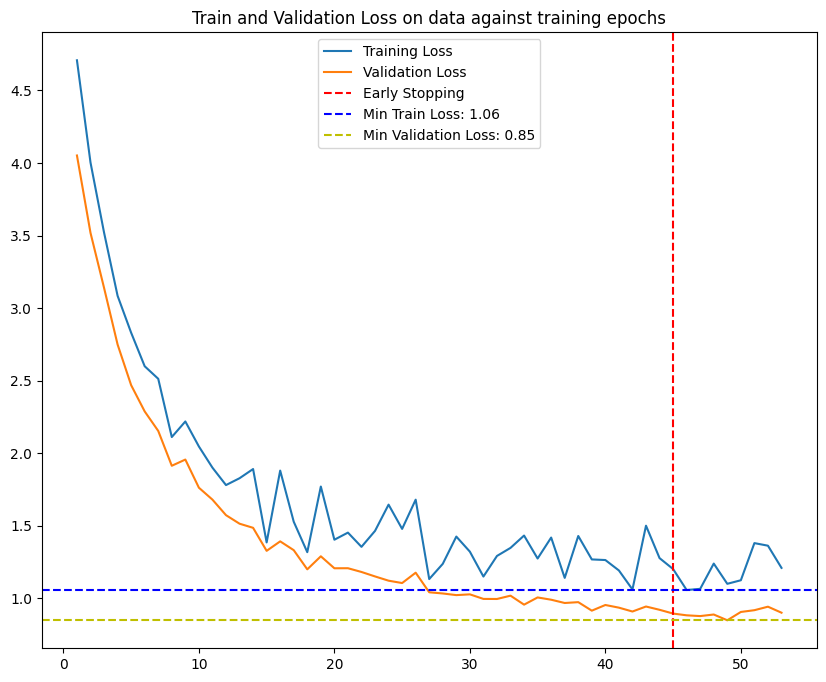

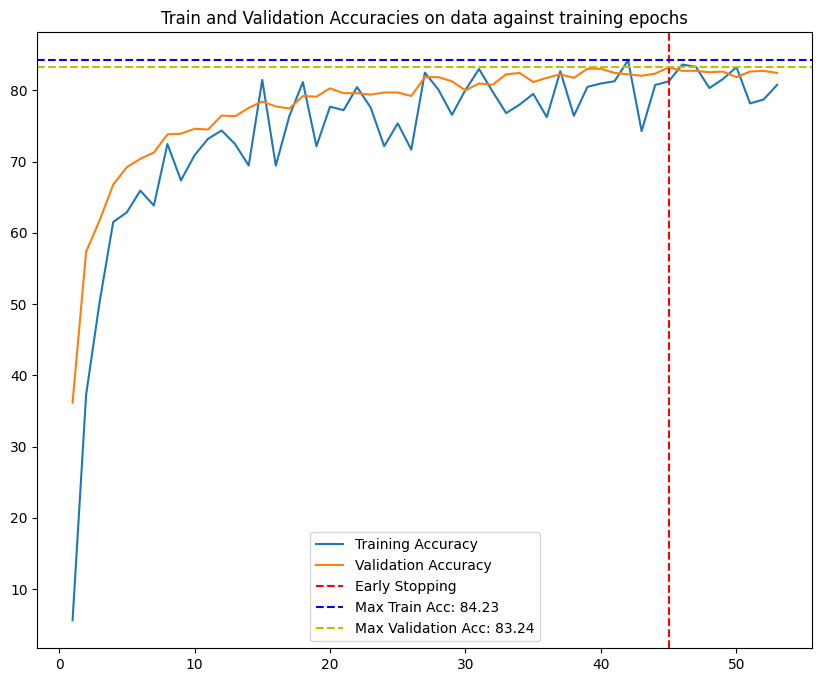

In [34]:
early_stopping_epoch = len(tr_loss)-8
min_train_loss = min(tr_loss)
min_test_loss = min(te_loss)
max_train_accuracy = max(tr_correct).cpu()
tr_correct1 = [i.cpu() for i in tr_correct]
te_correct1 = [i.cpu()*100 for i in te_correct]
max_test_accuracy = max(te_correct1).cpu()

fig = plt.figure(figsize=(10,8))
plt.title('Train and Validation Loss on data against training epochs')
plt.plot(range(1,len(tr_loss)+1),tr_loss, label='Training Loss')
plt.plot(range(1,len(te_loss)+1),te_loss,label='Validation Loss')
plt.axvline(x=early_stopping_epoch, color='r', linestyle='--', label='Early Stopping')
plt.axhline(y=min_train_loss, color='b', linestyle='--', label=f'Min Train Loss: {min_train_loss:.2f}')
plt.axhline(y=min_test_loss, color='y', linestyle='--', label=f'Min Validation Loss: {min_test_loss:.2f}')
plt.legend()
plt.show()

fig = plt.figure(figsize=(10,8))
plt.title('Train and Validation Accuracies on data against training epochs')
plt.plot(range(1,len(tr_correct1)+1),tr_correct1, label='Training Accuracy')
plt.plot(range(1,len(te_correct1)+1),te_correct1, label='Validation Accuracy')
plt.axvline(x=early_stopping_epoch, color='r', linestyle='--', label='Early Stopping')
plt.axhline(y=max_train_accuracy, color='b', linestyle='--', label=f'Max Train Acc: {max_train_accuracy:.2f}')
plt.axhline(y=max_test_accuracy, color='y', linestyle='--', label=f'Max Validation Acc: {max_test_accuracy:.2f}')
plt.legend()
plt.show()

In [35]:
correct = 0
total = 0
list_predicted = []
list_labels = []
with torch.no_grad():
    for data in tqdm(test_loader, desc='test'):
        images, labels = data
        images, labels = images.to(device), labels.to(device) # add this line
        outputs = model(images)

        _, predicted = torch.max(outputs.data, 1)
        predicted, labels = predicted.cpu(), labels.cpu()
        list_predicted.extend(predicted)
        list_labels.extend(labels)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print('Accuracy on test images: ', 100*(correct/total), '%')

acc_mix_up_and_aug = 100*(correct/total)
mixup_aug_f1 = f1_score(list_predicted, list_labels, average='weighted')

test:   0%|          | 0/193 [00:00<?, ?it/s]

Accuracy on test images:  80.12684989429175 %


In [36]:
print(classification_report(list_labels, list_predicted))

              precision    recall  f1-score   support

           0       0.39      0.80      0.52        20
           1       0.94      0.85      0.89        40
           2       0.50      0.30      0.37        20
           3       0.46      0.50      0.48        36
           4       0.87      0.73      0.80        45
           5       0.93      1.00      0.96        25
           6       0.55      0.80      0.65        20
           7       0.97      1.00      0.98        65
           8       0.81      0.85      0.83        26
           9       0.92      0.88      0.90        25
          10       0.62      0.64      0.63        67
          11       0.98      0.87      0.92        67
          12       0.86      0.86      0.86        29
          13       0.82      0.96      0.89        28
          14       0.47      0.93      0.63        29
          15       0.63      0.81      0.71        21
          16       1.00      0.89      0.94        65
          17       0.71    

In [37]:
c_m = confusion_matrix(list_labels, list_predicted, normalize='pred')

# Showing Confusion Matrix in form of 2D Numpy array
print(c_m)

[[0.3902439  0.02777778 0.         ... 0.         0.         0.        ]
 [0.         0.94444444 0.         ... 0.         0.         0.        ]
 [0.         0.         0.5        ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.8        0.         0.        ]
 [0.         0.         0.         ... 0.         0.65217391 0.        ]
 [0.         0.         0.         ... 0.         0.         0.875     ]]


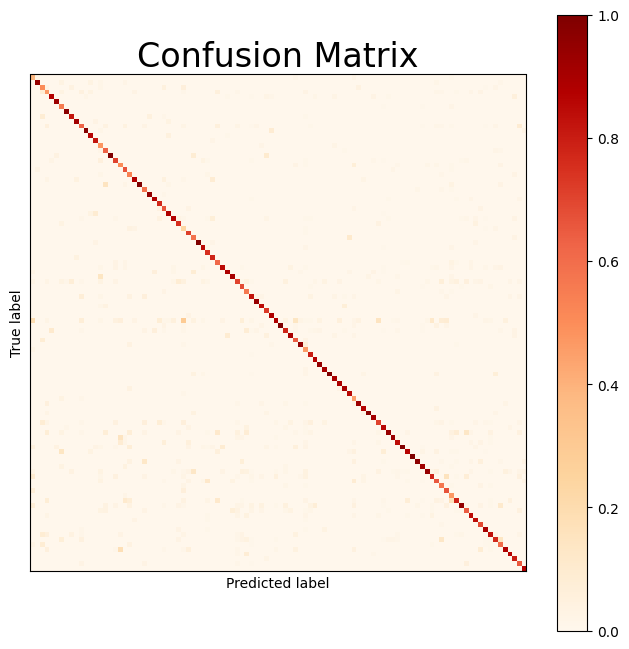

In [38]:
plt.rcParams['figure.figsize'] = (8, 8)
display_c_m = ConfusionMatrixDisplay(c_m)
display_c_m.plot(cmap='OrRd', include_values=False)

plt.title('Confusion Matrix', fontsize=24)

plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
# Showing the plot
plt.show()

In [39]:
print(f"""
Accuracy with augmentation Only: {aug_acc}%
F1 with augmentation Only: {aug_f1}
Accuracy with augmentation and mixup: {acc_mix_up_and_aug}%
F1 with augmentation and mixup {mixup_aug_f1}
""")


Accuracy with augmentation Only: 81.28150918848593%
F1 with augmentation Only: 0.8114039187153751
Accuracy with augmentation and mixup: 80.12684989429175%
F1 with augmentation and mixup 0.8011460716585523



#### Conclusion for mixup

So we can observe that helping mixup together with our augmentation helps the model generalise even better and improve our val acc.


### Experiement 3: How does complexity of classification layer affect

#### Complex Layer

We want to determine if additional layers will improve MobileNet V2

In [40]:
model = CustomMobileNet(102, 'custom')

In [41]:
criteria = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
early_stopper = EarlyStopper(patience=8, min_delta=0)

In [42]:

tr_loss, tr_correct = [], []
te_loss, te_correct = [], []
model.to(device)
best_model_wts = copy.deepcopy(model.state_dict())
best_acc = 0.0
for t in range(epochs):
    train_loss, train_correct = train_loop(train_aug_loader, model, criteria, optimizer)
    test_loss, test_correct = test_loop(valid_loader, model, criteria)

    tr_loss.append(train_loss), tr_correct.append(train_correct)
    te_loss.append(test_loss), te_correct.append(test_correct)
    print(f"Epoch {t+1}: Train_accuracy: {(train_correct*100):>0.2f}%, Train_loss: {train_loss:>8f}, Test_accuracy: {(100*test_correct):>0.2f}%, Test_loss: {test_loss:>8f}")

    if test_correct > best_acc:
        best_acc = test_correct
        best_model_wts = copy.deepcopy(model.state_dict())
        print(f'Best Accuracy currently: {best_acc}')

    if early_stopper.early_stop(test_correct.item()):
        print("Done!")
        break

train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 1: Train_accuracy: 9.02%, Train_loss: 4.479440, Test_accuracy: 36.86%, Test_loss: 3.774813
Best Accuracy currently: 0.3686274588108063


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 2: Train_accuracy: 35.88%, Train_loss: 3.151315, Test_accuracy: 46.18%, Test_loss: 2.412453
Best Accuracy currently: 0.46176472306251526


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 3: Train_accuracy: 54.51%, Train_loss: 1.980638, Test_accuracy: 61.96%, Test_loss: 1.632802
Best Accuracy currently: 0.6196078658103943


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 4: Train_accuracy: 66.37%, Train_loss: 1.401264, Test_accuracy: 65.98%, Test_loss: 1.377729
Best Accuracy currently: 0.6598039865493774


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 5: Train_accuracy: 71.96%, Train_loss: 1.155473, Test_accuracy: 70.39%, Test_loss: 1.178717
Best Accuracy currently: 0.7039216160774231


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 6: Train_accuracy: 78.92%, Train_loss: 0.872905, Test_accuracy: 70.88%, Test_loss: 1.080383
Best Accuracy currently: 0.708823561668396


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 7: Train_accuracy: 80.78%, Train_loss: 0.801770, Test_accuracy: 72.06%, Test_loss: 1.049365
Best Accuracy currently: 0.7205882668495178


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 8: Train_accuracy: 79.80%, Train_loss: 0.779202, Test_accuracy: 75.20%, Test_loss: 0.966968
Best Accuracy currently: 0.751960813999176


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 9: Train_accuracy: 82.25%, Train_loss: 0.701358, Test_accuracy: 72.94%, Test_loss: 0.976417


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 10: Train_accuracy: 82.94%, Train_loss: 0.646281, Test_accuracy: 76.37%, Test_loss: 0.882649
Best Accuracy currently: 0.7637255191802979


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 11: Train_accuracy: 83.53%, Train_loss: 0.601361, Test_accuracy: 76.37%, Test_loss: 0.870750


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 12: Train_accuracy: 85.10%, Train_loss: 0.557642, Test_accuracy: 76.86%, Test_loss: 0.791896
Best Accuracy currently: 0.7686275243759155


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 13: Train_accuracy: 86.86%, Train_loss: 0.506645, Test_accuracy: 78.33%, Test_loss: 0.821883
Best Accuracy currently: 0.7833333611488342


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 14: Train_accuracy: 86.37%, Train_loss: 0.544749, Test_accuracy: 79.90%, Test_loss: 0.754909
Best Accuracy currently: 0.7990196347236633


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 15: Train_accuracy: 84.71%, Train_loss: 0.556060, Test_accuracy: 78.24%, Test_loss: 0.842039


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 16: Train_accuracy: 86.57%, Train_loss: 0.479814, Test_accuracy: 79.90%, Test_loss: 0.817610


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 17: Train_accuracy: 88.04%, Train_loss: 0.449728, Test_accuracy: 80.00%, Test_loss: 0.747287
Best Accuracy currently: 0.8000000715255737


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 18: Train_accuracy: 85.88%, Train_loss: 0.522967, Test_accuracy: 78.14%, Test_loss: 0.767759


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 19: Train_accuracy: 88.73%, Train_loss: 0.437865, Test_accuracy: 78.33%, Test_loss: 0.760489


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 20: Train_accuracy: 88.53%, Train_loss: 0.443391, Test_accuracy: 79.22%, Test_loss: 0.754395


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 21: Train_accuracy: 88.33%, Train_loss: 0.434480, Test_accuracy: 76.27%, Test_loss: 0.821036


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 22: Train_accuracy: 88.43%, Train_loss: 0.399937, Test_accuracy: 79.31%, Test_loss: 0.758045


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 23: Train_accuracy: 89.80%, Train_loss: 0.388705, Test_accuracy: 79.31%, Test_loss: 0.755901


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 24: Train_accuracy: 89.31%, Train_loss: 0.378613, Test_accuracy: 77.94%, Test_loss: 0.815798


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 25: Train_accuracy: 89.22%, Train_loss: 0.402334, Test_accuracy: 77.94%, Test_loss: 0.807702
Done!


In [43]:
model.load_state_dict(best_model_wts)

<All keys matched successfully>

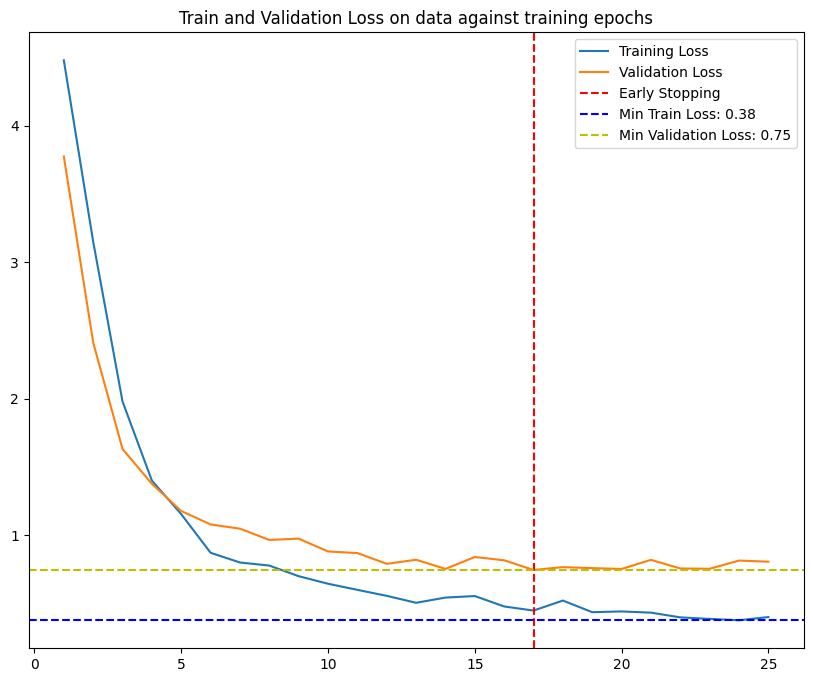

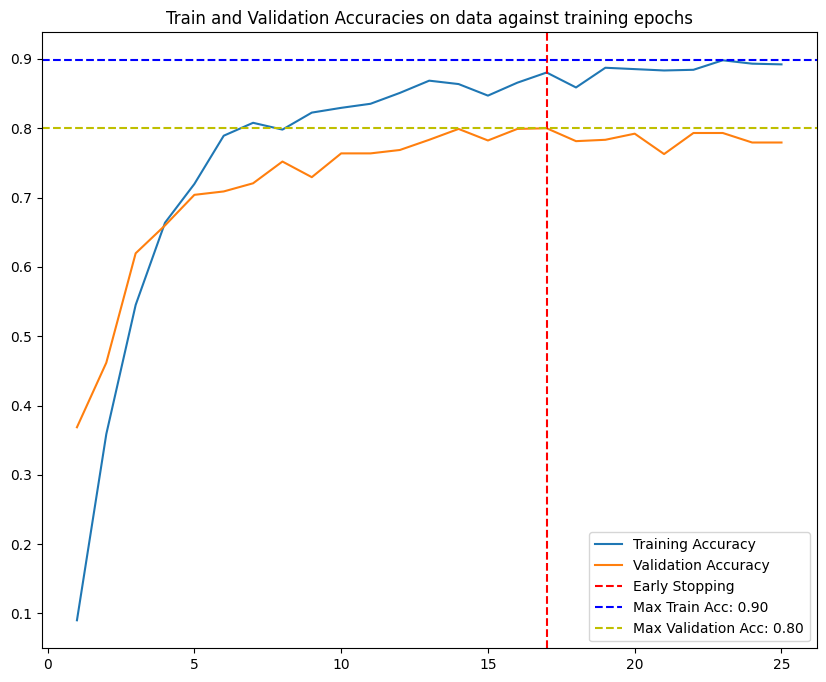

In [44]:
early_stopping_epoch = len(tr_loss)-8
min_train_loss = min(tr_loss)
min_test_loss = min(te_loss)
max_train_accuracy = max(tr_correct).cpu()
max_test_accuracy = max(te_correct).cpu()
tr_correct1 = [i.cpu() for i in tr_correct]
te_correct1 = [i.cpu() for i in te_correct]

fig = plt.figure(figsize=(10,8))
plt.title('Train and Validation Loss on data against training epochs')
plt.plot(range(1,len(tr_loss)+1),tr_loss, label='Training Loss')
plt.plot(range(1,len(te_loss)+1),te_loss,label='Validation Loss')
plt.axvline(x=early_stopping_epoch, color='r', linestyle='--', label='Early Stopping')
plt.axhline(y=min_train_loss, color='b', linestyle='--', label=f'Min Train Loss: {min_train_loss:.2f}')
plt.axhline(y=min_test_loss, color='y', linestyle='--', label=f'Min Validation Loss: {min_test_loss:.2f}')
plt.legend()
plt.show()

fig = plt.figure(figsize=(10,8))
plt.title('Train and Validation Accuracies on data against training epochs')
plt.plot(range(1,len(tr_correct1)+1),tr_correct1, label='Training Accuracy')
plt.plot(range(1,len(te_correct1)+1),te_correct1, label='Validation Accuracy')
plt.axvline(x=early_stopping_epoch, color='r', linestyle='--', label='Early Stopping')
plt.axhline(y=max_train_accuracy, color='b', linestyle='--', label=f'Max Train Acc: {max_train_accuracy:.2f}')
plt.axhline(y=max_test_accuracy, color='y', linestyle='--', label=f'Max Validation Acc: {max_test_accuracy:.2f}')
plt.legend()

In [45]:
correct = 0
total = 0
list_predicted = []
list_labels = []
with torch.no_grad():
    for data in tqdm(test_loader, desc='test'):
        images, labels = data
        images, labels = images.to(device), labels.to(device) # add this line
        outputs = model(images)

        _, predicted = torch.max(outputs.data, 1)
        predicted, labels = predicted.cpu(), labels.cpu()
        list_predicted.extend(predicted)
        list_labels.extend(labels)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print('Accuracy on test images: ', 100*(correct/total), '%')

complex_acc = 100*(correct/total)
complex_f1 = f1_score(list_predicted, list_labels, average='weighted')

test:   0%|          | 0/193 [00:00<?, ?it/s]

Accuracy on test images:  77.80126849894292 %


In [46]:
print(classification_report(list_labels, list_predicted))

              precision    recall  f1-score   support

           0       0.22      0.85      0.35        20
           1       0.93      0.93      0.93        40
           2       0.10      0.35      0.15        20
           3       0.50      0.28      0.36        36
           4       0.89      0.71      0.79        45
           5       1.00      0.92      0.96        25
           6       0.64      0.80      0.71        20
           7       0.91      0.95      0.93        65
           8       0.79      0.73      0.76        26
           9       0.73      0.96      0.83        25
          10       0.65      0.63      0.64        67
          11       0.93      0.93      0.93        67
          12       0.73      0.93      0.82        29
          13       0.92      0.79      0.85        28
          14       0.68      0.97      0.80        29
          15       0.69      0.95      0.80        21
          16       0.97      0.92      0.94        65
          17       0.78    

In [47]:
c_m = confusion_matrix(list_labels, list_predicted, normalize='pred')

# Showing Confusion Matrix in form of 2D Numpy array
print(c_m)

[[0.22077922 0.025      0.01369863 ... 0.         0.         0.        ]
 [0.         0.925      0.01369863 ... 0.         0.         0.        ]
 [0.         0.         0.09589041 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.96       0.         0.        ]
 [0.         0.         0.         ... 0.         0.55384615 0.        ]
 [0.         0.         0.         ... 0.         0.         0.96428571]]


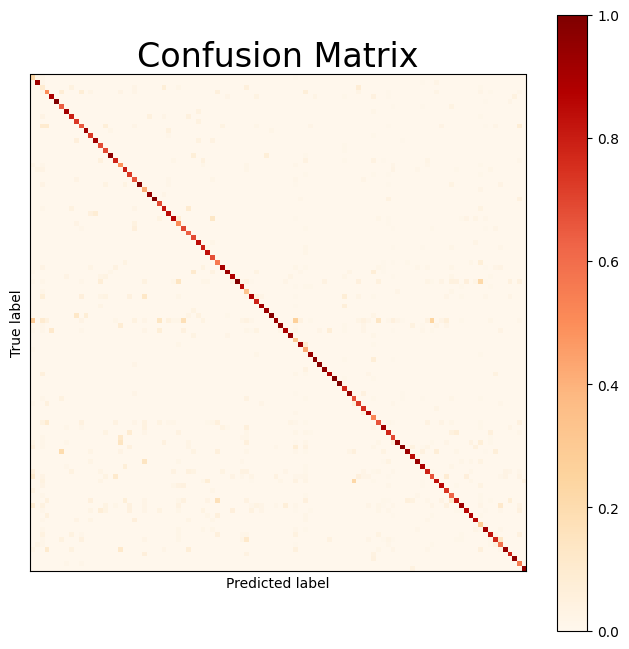

In [48]:
plt.rcParams['figure.figsize'] = (8, 8)
display_c_m = ConfusionMatrixDisplay(c_m)
display_c_m.plot(cmap='OrRd', include_values=False)

plt.title('Confusion Matrix', fontsize=24)

plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
# Showing the plot
plt.show()

In [49]:
print(f"""
Accuracy with augmentation Only: {aug_acc}%
F1 with augmentation Only: {aug_f1}
Accuracy with augmentation Complex Classification Layer: {complex_acc}%
F1 with augmentation Complex Classification Layer {complex_f1}
""")


Accuracy with augmentation Only: 81.28150918848593%
F1 with augmentation Only: 0.8114039187153751
Accuracy with augmentation Complex Classification Layer: 77.80126849894292%
F1 with augmentation Complex Classification Layer 0.7736055337329578



Simple classification layer

In [50]:
model = CustomMobileNet(102, 'simple')

In [51]:
criteria = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
early_stopper = EarlyStopper(patience=8, min_delta=0)

In [52]:
tr_loss, tr_correct = [], []
te_loss, te_correct = [], []
model.to(device)
best_model_wts = copy.deepcopy(model.state_dict())
best_acc = 0.0
for t in range(epochs):
    train_loss, train_correct = train_loop(train_aug_loader, model, criteria, optimizer)
    test_loss, test_correct = test_loop(valid_loader, model, criteria)

    tr_loss.append(train_loss), tr_correct.append(train_correct)
    te_loss.append(test_loss), te_correct.append(test_correct)
    print(f"Epoch {t+1}: Train_accuracy: {(train_correct*100):>0.2f}%, Train_loss: {train_loss:>8f}, Test_accuracy: {(100*test_correct):>0.2f}%, Test_loss: {test_loss:>8f}")

    if test_correct > best_acc:
        best_acc = test_correct
        best_model_wts = copy.deepcopy(model.state_dict())
        print(f'Best Accuracy currently: {best_acc}')

    if early_stopper.early_stop(test_correct.item()):
        print("Done!")
        break

train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 1: Train_accuracy: 10.29%, Train_loss: 4.457229, Test_accuracy: 46.86%, Test_loss: 3.881048
Best Accuracy currently: 0.4686274826526642


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 2: Train_accuracy: 55.69%, Train_loss: 3.542206, Test_accuracy: 62.45%, Test_loss: 3.252590
Best Accuracy currently: 0.6245098114013672


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 3: Train_accuracy: 69.31%, Train_loss: 2.923044, Test_accuracy: 67.16%, Test_loss: 2.781615
Best Accuracy currently: 0.6715686917304993


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 4: Train_accuracy: 76.67%, Train_loss: 2.387254, Test_accuracy: 70.69%, Test_loss: 2.366995
Best Accuracy currently: 0.7068628072738647


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 5: Train_accuracy: 79.51%, Train_loss: 2.029044, Test_accuracy: 73.04%, Test_loss: 2.085817
Best Accuracy currently: 0.7303922176361084


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 6: Train_accuracy: 82.45%, Train_loss: 1.754359, Test_accuracy: 74.90%, Test_loss: 1.842592
Best Accuracy currently: 0.7490196228027344


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 7: Train_accuracy: 84.41%, Train_loss: 1.537333, Test_accuracy: 76.76%, Test_loss: 1.682682
Best Accuracy currently: 0.7676470875740051


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 8: Train_accuracy: 84.90%, Train_loss: 1.374375, Test_accuracy: 77.45%, Test_loss: 1.547478
Best Accuracy currently: 0.774509847164154


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 9: Train_accuracy: 87.25%, Train_loss: 1.220559, Test_accuracy: 77.25%, Test_loss: 1.461082


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 10: Train_accuracy: 86.86%, Train_loss: 1.142684, Test_accuracy: 77.94%, Test_loss: 1.387495
Best Accuracy currently: 0.779411792755127


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 11: Train_accuracy: 88.14%, Train_loss: 1.016255, Test_accuracy: 78.92%, Test_loss: 1.274649
Best Accuracy currently: 0.7892157435417175


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 12: Train_accuracy: 88.63%, Train_loss: 0.951321, Test_accuracy: 80.39%, Test_loss: 1.210410
Best Accuracy currently: 0.803921639919281


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 13: Train_accuracy: 87.94%, Train_loss: 0.909310, Test_accuracy: 78.33%, Test_loss: 1.204023


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 14: Train_accuracy: 89.90%, Train_loss: 0.815980, Test_accuracy: 80.20%, Test_loss: 1.109753


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 15: Train_accuracy: 88.63%, Train_loss: 0.796222, Test_accuracy: 80.29%, Test_loss: 1.094081


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 16: Train_accuracy: 89.31%, Train_loss: 0.753991, Test_accuracy: 79.80%, Test_loss: 1.062290


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 17: Train_accuracy: 91.18%, Train_loss: 0.698420, Test_accuracy: 80.29%, Test_loss: 1.040491


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 18: Train_accuracy: 91.67%, Train_loss: 0.626879, Test_accuracy: 80.29%, Test_loss: 0.987675


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 19: Train_accuracy: 90.59%, Train_loss: 0.675703, Test_accuracy: 80.00%, Test_loss: 0.982142


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 20: Train_accuracy: 90.39%, Train_loss: 0.638012, Test_accuracy: 81.57%, Test_loss: 0.958748
Best Accuracy currently: 0.8156863451004028


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 21: Train_accuracy: 90.78%, Train_loss: 0.617221, Test_accuracy: 80.88%, Test_loss: 0.932319


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 22: Train_accuracy: 92.25%, Train_loss: 0.562424, Test_accuracy: 82.25%, Test_loss: 0.888760
Best Accuracy currently: 0.822549045085907


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 23: Train_accuracy: 92.06%, Train_loss: 0.566008, Test_accuracy: 81.76%, Test_loss: 0.886711


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 24: Train_accuracy: 92.16%, Train_loss: 0.569715, Test_accuracy: 80.78%, Test_loss: 0.880824


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 25: Train_accuracy: 91.47%, Train_loss: 0.537520, Test_accuracy: 80.39%, Test_loss: 0.877692


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 26: Train_accuracy: 91.57%, Train_loss: 0.538765, Test_accuracy: 81.47%, Test_loss: 0.851164


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 27: Train_accuracy: 92.84%, Train_loss: 0.483520, Test_accuracy: 81.57%, Test_loss: 0.833993


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 28: Train_accuracy: 93.14%, Train_loss: 0.475917, Test_accuracy: 82.84%, Test_loss: 0.823388
Best Accuracy currently: 0.8284314274787903


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 29: Train_accuracy: 92.25%, Train_loss: 0.526307, Test_accuracy: 80.98%, Test_loss: 0.820571


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 30: Train_accuracy: 92.65%, Train_loss: 0.479025, Test_accuracy: 81.76%, Test_loss: 0.825402


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 31: Train_accuracy: 93.24%, Train_loss: 0.437949, Test_accuracy: 81.86%, Test_loss: 0.810661


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 32: Train_accuracy: 93.53%, Train_loss: 0.442229, Test_accuracy: 82.45%, Test_loss: 0.778037


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 33: Train_accuracy: 92.94%, Train_loss: 0.445702, Test_accuracy: 82.45%, Test_loss: 0.773629


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 34: Train_accuracy: 91.96%, Train_loss: 0.460997, Test_accuracy: 80.88%, Test_loss: 0.773871


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 35: Train_accuracy: 93.33%, Train_loss: 0.413724, Test_accuracy: 81.67%, Test_loss: 0.769874


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 36: Train_accuracy: 94.12%, Train_loss: 0.389432, Test_accuracy: 82.16%, Test_loss: 0.775232
Done!


In [53]:
model.load_state_dict(best_model_wts)

<All keys matched successfully>

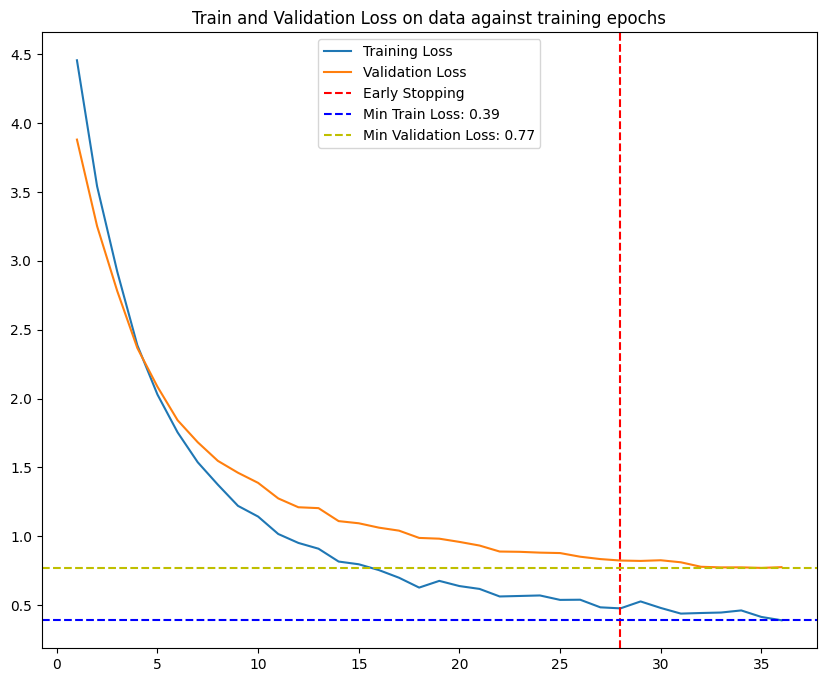

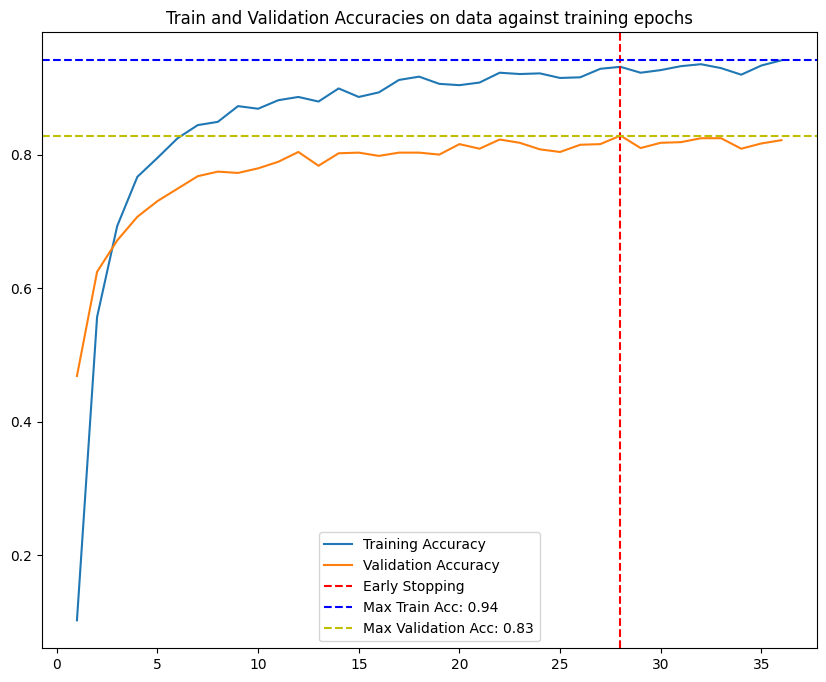

In [54]:
early_stopping_epoch = len(tr_loss)-8
min_train_loss = min(tr_loss)
min_test_loss = min(te_loss)
max_train_accuracy = max(tr_correct).cpu()
max_test_accuracy = max(te_correct).cpu()
tr_correct1 = [i.cpu() for i in tr_correct]
te_correct1 = [i.cpu() for i in te_correct]

fig = plt.figure(figsize=(10,8))
plt.title('Train and Validation Loss on data against training epochs')
plt.plot(range(1,len(tr_loss)+1),tr_loss, label='Training Loss')
plt.plot(range(1,len(te_loss)+1),te_loss,label='Validation Loss')
plt.axvline(x=early_stopping_epoch, color='r', linestyle='--', label='Early Stopping')
plt.axhline(y=min_train_loss, color='b', linestyle='--', label=f'Min Train Loss: {min_train_loss:.2f}')
plt.axhline(y=min_test_loss, color='y', linestyle='--', label=f'Min Validation Loss: {min_test_loss:.2f}')
plt.legend()
plt.show()

fig = plt.figure(figsize=(10,8))
plt.title('Train and Validation Accuracies on data against training epochs')
plt.plot(range(1,len(tr_correct1)+1),tr_correct1, label='Training Accuracy')
plt.plot(range(1,len(te_correct1)+1),te_correct1, label='Validation Accuracy')
plt.axvline(x=early_stopping_epoch, color='r', linestyle='--', label='Early Stopping')
plt.axhline(y=max_train_accuracy, color='b', linestyle='--', label=f'Max Train Acc: {max_train_accuracy:.2f}')
plt.axhline(y=max_test_accuracy, color='y', linestyle='--', label=f'Max Validation Acc: {max_test_accuracy:.2f}')
plt.legend()

In [55]:
correct = 0
total = 0
list_predicted = []
list_labels = []
with torch.no_grad():
    for data in tqdm(test_loader, desc='test'):
        images, labels = data
        images, labels = images.to(device), labels.to(device) # add this line
        outputs = model(images)

        _, predicted = torch.max(outputs.data, 1)
        predicted, labels = predicted.cpu(), labels.cpu()
        list_predicted.extend(predicted)
        list_labels.extend(labels)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print('Accuracy on test images: ', 100*(correct/total), '%')

simple_acc = 100*(correct/total)
simple_f1 = f1_score(list_predicted, list_labels, average='weighted')

test:   0%|          | 0/193 [00:00<?, ?it/s]

Accuracy on test images:  80.43584322654091 %


In [56]:
print(classification_report(list_labels, list_predicted))

              precision    recall  f1-score   support

           0       0.53      0.80      0.64        20
           1       0.97      0.78      0.86        40
           2       0.46      0.30      0.36        20
           3       0.76      0.36      0.49        36
           4       0.87      0.76      0.81        45
           5       0.88      0.92      0.90        25
           6       0.47      0.90      0.62        20
           7       0.92      1.00      0.96        65
           8       0.95      0.81      0.88        26
           9       0.85      0.92      0.88        25
          10       0.70      0.66      0.68        67
          11       0.98      0.85      0.91        67
          12       0.72      0.97      0.82        29
          13       0.72      1.00      0.84        28
          14       0.70      0.90      0.79        29
          15       0.77      0.81      0.79        21
          16       0.98      0.88      0.93        65
          17       0.73    

In [57]:
c_m = confusion_matrix(list_labels, list_predicted, normalize='pred')

# Showing Confusion Matrix in form of 2D Numpy array
print(c_m)

[[0.53333333 0.03125    0.         ... 0.         0.         0.        ]
 [0.         0.96875    0.         ... 0.         0.         0.03225806]
 [0.         0.         0.46153846 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.84375    0.         0.        ]
 [0.         0.         0.         ... 0.         0.69565217 0.        ]
 [0.         0.         0.         ... 0.         0.         0.90322581]]


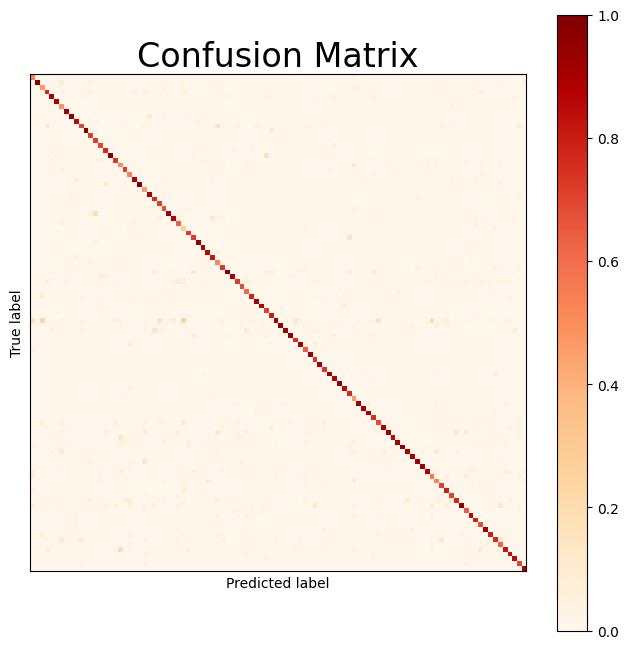

In [58]:
plt.rcParams['figure.figsize'] = (8, 8)
display_c_m = ConfusionMatrixDisplay(c_m)
display_c_m.plot(cmap='OrRd', include_values=False)

plt.title('Confusion Matrix', fontsize=24)

plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
# Showing the plot
plt.show()

In [59]:
print(f"""
Accuracy with augmentation Only: {aug_acc}%
F1 with augmentation Only: {aug_f1}
Accuracy with augmentation Simple Classification Layer: {simple_acc}%
F1 with augmentation Simple Classification Layer {simple_f1}
""")


Accuracy with augmentation Only: 81.28150918848593%
F1 with augmentation Only: 0.8114039187153751
Accuracy with augmentation Simple Classification Layer: 80.43584322654091%
F1 with augmentation Simple Classification Layer 0.8066540881664127



#### Conclusion for MobileNet

Having a simple classifier i.e one linear layer after convolution, is better for this dataset as the model will not overfit

### Fine Tuning MobileNet

To fine tune mobilenet to get the best model, we will first train a mobilenet model with data augmentation.

Next we will unfreeze all classification layers + the last inverted residual layer and set learning rate to be 0.0001 using Adam Optimizer

In [60]:
model = CustomMobileNet(102, 'simple')

In [61]:
model

CustomMobileNet(
  (backbone): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, 

In [62]:
criteria = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
early_stopper = EarlyStopper(patience=8, min_delta=0)

In [63]:
tr_loss, tr_correct = [], []
te_loss, te_correct = [], []
model.to(device)
best_model_wts = copy.deepcopy(model.state_dict())
best_acc = 0.0
for t in range(epochs):
    train_loss, train_correct = train_loop(train_aug_loader, model, criteria, optimizer)
    test_loss, test_correct = test_loop(valid_loader, model, criteria)

    tr_loss.append(train_loss), tr_correct.append(train_correct)
    te_loss.append(test_loss), te_correct.append(test_correct)
    print(f"Epoch {t+1}: Train_accuracy: {(train_correct*100):>0.2f}%, Train_loss: {train_loss:>8f}, Test_accuracy: {(100*test_correct):>0.2f}%, Test_loss: {test_loss:>8f}")

    if test_correct > best_acc:
        best_acc = test_correct
        best_model_wts = copy.deepcopy(model.state_dict())
        print(f'Best Accuracy currently: {best_acc}')

    if early_stopper.early_stop(test_correct.item()):
        print("Done!")
        break

train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 1: Train_accuracy: 8.82%, Train_loss: 4.473140, Test_accuracy: 42.94%, Test_loss: 3.886869
Best Accuracy currently: 0.42941179871559143


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 2: Train_accuracy: 50.20%, Train_loss: 3.589725, Test_accuracy: 57.45%, Test_loss: 3.277480
Best Accuracy currently: 0.574509859085083


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 3: Train_accuracy: 67.75%, Train_loss: 2.943829, Test_accuracy: 65.88%, Test_loss: 2.789889
Best Accuracy currently: 0.658823549747467


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 4: Train_accuracy: 72.65%, Train_loss: 2.460914, Test_accuracy: 69.51%, Test_loss: 2.441683
Best Accuracy currently: 0.6950981020927429


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 5: Train_accuracy: 79.12%, Train_loss: 2.094811, Test_accuracy: 73.14%, Test_loss: 2.075461
Best Accuracy currently: 0.731372594833374


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 6: Train_accuracy: 82.16%, Train_loss: 1.808306, Test_accuracy: 72.65%, Test_loss: 1.920745


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 7: Train_accuracy: 83.82%, Train_loss: 1.552858, Test_accuracy: 74.22%, Test_loss: 1.731135
Best Accuracy currently: 0.7421569228172302


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 8: Train_accuracy: 83.82%, Train_loss: 1.415206, Test_accuracy: 76.18%, Test_loss: 1.586993
Best Accuracy currently: 0.7617647647857666


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 9: Train_accuracy: 86.08%, Train_loss: 1.246196, Test_accuracy: 76.67%, Test_loss: 1.494173
Best Accuracy currently: 0.7666667103767395


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 10: Train_accuracy: 86.96%, Train_loss: 1.108364, Test_accuracy: 77.35%, Test_loss: 1.384358
Best Accuracy currently: 0.7735294699668884


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 11: Train_accuracy: 87.94%, Train_loss: 1.054771, Test_accuracy: 78.14%, Test_loss: 1.311334
Best Accuracy currently: 0.781372606754303


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 12: Train_accuracy: 88.43%, Train_loss: 0.951612, Test_accuracy: 80.49%, Test_loss: 1.215079
Best Accuracy currently: 0.8049020171165466


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 13: Train_accuracy: 89.61%, Train_loss: 0.877463, Test_accuracy: 80.00%, Test_loss: 1.190816


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 14: Train_accuracy: 90.00%, Train_loss: 0.837751, Test_accuracy: 80.59%, Test_loss: 1.132429
Best Accuracy currently: 0.8058823943138123


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 15: Train_accuracy: 90.39%, Train_loss: 0.739601, Test_accuracy: 81.47%, Test_loss: 1.072411
Best Accuracy currently: 0.8147059082984924


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 16: Train_accuracy: 90.98%, Train_loss: 0.741426, Test_accuracy: 80.88%, Test_loss: 1.068131


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 17: Train_accuracy: 89.31%, Train_loss: 0.732724, Test_accuracy: 81.86%, Test_loss: 1.008374
Best Accuracy currently: 0.8186274766921997


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 18: Train_accuracy: 90.78%, Train_loss: 0.683619, Test_accuracy: 80.29%, Test_loss: 1.020916


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 19: Train_accuracy: 91.08%, Train_loss: 0.645666, Test_accuracy: 81.57%, Test_loss: 0.981736


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 20: Train_accuracy: 91.08%, Train_loss: 0.631003, Test_accuracy: 80.69%, Test_loss: 0.960532


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 21: Train_accuracy: 90.29%, Train_loss: 0.642224, Test_accuracy: 81.67%, Test_loss: 0.931966


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 22: Train_accuracy: 90.88%, Train_loss: 0.609374, Test_accuracy: 81.47%, Test_loss: 0.906164


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 23: Train_accuracy: 93.73%, Train_loss: 0.530978, Test_accuracy: 82.06%, Test_loss: 0.901588
Best Accuracy currently: 0.8205882906913757


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 24: Train_accuracy: 91.08%, Train_loss: 0.548096, Test_accuracy: 82.84%, Test_loss: 0.857837
Best Accuracy currently: 0.8284314274787903


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 25: Train_accuracy: 93.04%, Train_loss: 0.526234, Test_accuracy: 83.04%, Test_loss: 0.862860
Best Accuracy currently: 0.8303921818733215


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 26: Train_accuracy: 92.06%, Train_loss: 0.516608, Test_accuracy: 82.16%, Test_loss: 0.852219


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 27: Train_accuracy: 92.84%, Train_loss: 0.470070, Test_accuracy: 83.33%, Test_loss: 0.802969
Best Accuracy currently: 0.8333333730697632


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 28: Train_accuracy: 92.45%, Train_loss: 0.504574, Test_accuracy: 82.94%, Test_loss: 0.817364


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 29: Train_accuracy: 93.04%, Train_loss: 0.450751, Test_accuracy: 83.43%, Test_loss: 0.803121
Best Accuracy currently: 0.8343137502670288


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 30: Train_accuracy: 93.14%, Train_loss: 0.477667, Test_accuracy: 83.82%, Test_loss: 0.786564
Best Accuracy currently: 0.8382353186607361


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 31: Train_accuracy: 93.73%, Train_loss: 0.467212, Test_accuracy: 82.94%, Test_loss: 0.796483


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 32: Train_accuracy: 92.84%, Train_loss: 0.428755, Test_accuracy: 83.14%, Test_loss: 0.775985


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 33: Train_accuracy: 93.53%, Train_loss: 0.417937, Test_accuracy: 83.92%, Test_loss: 0.770817
Best Accuracy currently: 0.8392157554626465


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 34: Train_accuracy: 93.53%, Train_loss: 0.415247, Test_accuracy: 82.94%, Test_loss: 0.761472


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 35: Train_accuracy: 92.75%, Train_loss: 0.437407, Test_accuracy: 83.24%, Test_loss: 0.740697


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 36: Train_accuracy: 93.24%, Train_loss: 0.418485, Test_accuracy: 82.84%, Test_loss: 0.757330


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 37: Train_accuracy: 93.33%, Train_loss: 0.394553, Test_accuracy: 83.63%, Test_loss: 0.747118


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 38: Train_accuracy: 93.53%, Train_loss: 0.378155, Test_accuracy: 82.55%, Test_loss: 0.740931


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 39: Train_accuracy: 91.96%, Train_loss: 0.436389, Test_accuracy: 82.84%, Test_loss: 0.750304


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 40: Train_accuracy: 94.02%, Train_loss: 0.363848, Test_accuracy: 83.24%, Test_loss: 0.750214


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 41: Train_accuracy: 93.92%, Train_loss: 0.388246, Test_accuracy: 84.22%, Test_loss: 0.732334
Best Accuracy currently: 0.8421568870544434


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 42: Train_accuracy: 93.92%, Train_loss: 0.370096, Test_accuracy: 83.43%, Test_loss: 0.722632


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 43: Train_accuracy: 93.73%, Train_loss: 0.358137, Test_accuracy: 83.24%, Test_loss: 0.735657


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 44: Train_accuracy: 94.02%, Train_loss: 0.334919, Test_accuracy: 83.53%, Test_loss: 0.734283


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 45: Train_accuracy: 94.51%, Train_loss: 0.322495, Test_accuracy: 83.92%, Test_loss: 0.719985


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 46: Train_accuracy: 93.92%, Train_loss: 0.346505, Test_accuracy: 83.24%, Test_loss: 0.704171


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 47: Train_accuracy: 94.51%, Train_loss: 0.307960, Test_accuracy: 83.63%, Test_loss: 0.707531


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 48: Train_accuracy: 94.22%, Train_loss: 0.314452, Test_accuracy: 83.43%, Test_loss: 0.705278


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 49: Train_accuracy: 93.53%, Train_loss: 0.352711, Test_accuracy: 82.65%, Test_loss: 0.708160
Done!


In [64]:
model.load_state_dict(best_model_wts)

<All keys matched successfully>

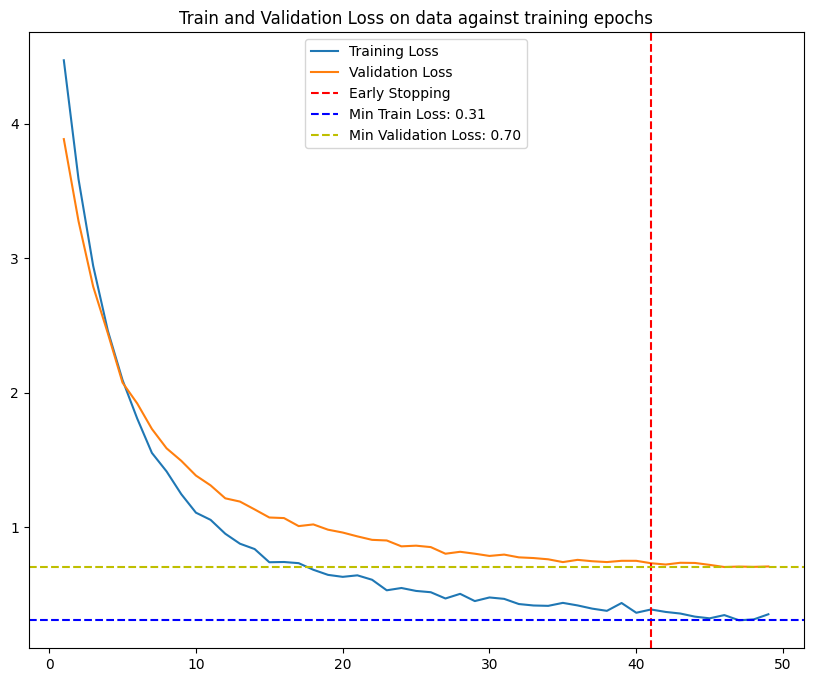

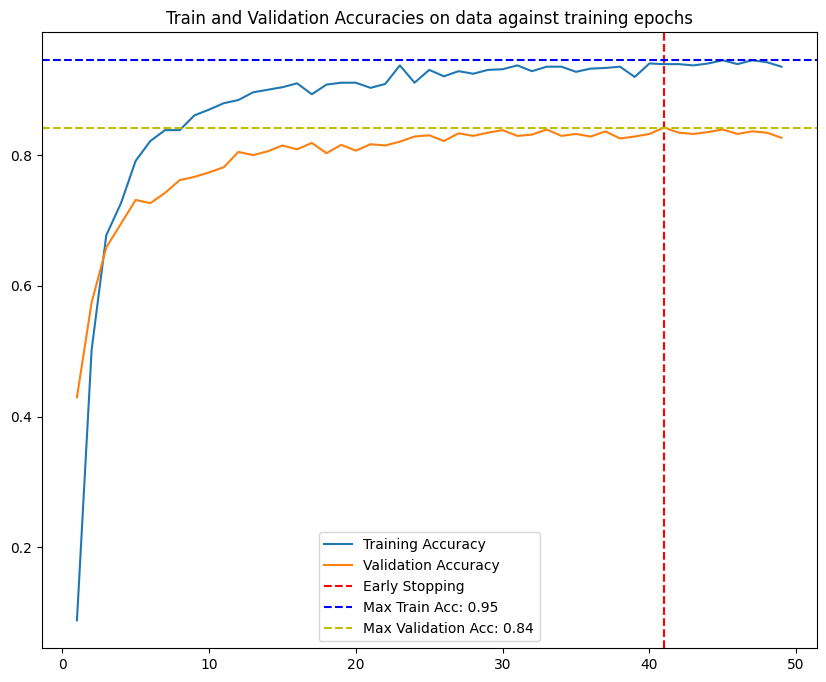

In [65]:
early_stopping_epoch = len(tr_loss)-8
min_train_loss = min(tr_loss)
min_test_loss = min(te_loss)
max_train_accuracy = max(tr_correct).cpu()
max_test_accuracy = max(te_correct).cpu()
tr_correct1 = [i.cpu() for i in tr_correct]
te_correct1 = [i.cpu() for i in te_correct]

fig = plt.figure(figsize=(10,8))
plt.title('Train and Validation Loss on data against training epochs')
plt.plot(range(1,len(tr_loss)+1),tr_loss, label='Training Loss')
plt.plot(range(1,len(te_loss)+1),te_loss,label='Validation Loss')
plt.axvline(x=early_stopping_epoch, color='r', linestyle='--', label='Early Stopping')
plt.axhline(y=min_train_loss, color='b', linestyle='--', label=f'Min Train Loss: {min_train_loss:.2f}')
plt.axhline(y=min_test_loss, color='y', linestyle='--', label=f'Min Validation Loss: {min_test_loss:.2f}')
plt.legend()
plt.show()

fig = plt.figure(figsize=(10,8))
plt.title('Train and Validation Accuracies on data against training epochs')
plt.plot(range(1,len(tr_correct1)+1),tr_correct1, label='Training Accuracy')
plt.plot(range(1,len(te_correct1)+1),te_correct1, label='Validation Accuracy')
plt.axvline(x=early_stopping_epoch, color='r', linestyle='--', label='Early Stopping')
plt.axhline(y=max_train_accuracy, color='b', linestyle='--', label=f'Max Train Acc: {max_train_accuracy:.2f}')
plt.axhline(y=max_test_accuracy, color='y', linestyle='--', label=f'Max Validation Acc: {max_test_accuracy:.2f}')
plt.legend()

In [66]:
# Unfreeze last Inverted Residual layer
for param in model.backbone[17:].parameters():
    param.requires_grad = True

In [67]:
optimizer = optim.Adam(model.parameters(), lr=0.0001)
early_stopper = EarlyStopper(patience=8, min_delta=0)
epochs=30

In [68]:
tr_loss, tr_correct = [], []
te_loss, te_correct = [], []
model.to(device)
best_model_wts = copy.deepcopy(model.state_dict())
best_acc = 0.0
for t in range(epochs):
    train_loss, train_correct = train_loop(train_aug_loader, model, criteria, optimizer)
    test_loss, test_correct = test_loop(valid_loader, model, criteria)

    tr_loss.append(train_loss), tr_correct.append(train_correct)
    te_loss.append(test_loss), te_correct.append(test_correct)
    print(f"Epoch {t+1}: Train_accuracy: {(train_correct*100):>0.2f}%, Train_loss: {train_loss:>8f}, Test_accuracy: {(100*test_correct):>0.2f}%, Test_loss: {test_loss:>8f}")

    if test_correct > best_acc:
        best_acc = test_correct
        best_model_wts = copy.deepcopy(model.state_dict())
        print(f'Best Accuracy currently: {best_acc}')

    if early_stopper.early_stop(test_correct.item()):
        print("Done!")
        break

train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 1: Train_accuracy: 93.53%, Train_loss: 0.355869, Test_accuracy: 84.31%, Test_loss: 0.698729
Best Accuracy currently: 0.8431373238563538


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 2: Train_accuracy: 92.35%, Train_loss: 0.342814, Test_accuracy: 85.29%, Test_loss: 0.645835
Best Accuracy currently: 0.8529412150382996


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 3: Train_accuracy: 95.49%, Train_loss: 0.284167, Test_accuracy: 84.80%, Test_loss: 0.657044


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 4: Train_accuracy: 93.14%, Train_loss: 0.302805, Test_accuracy: 84.31%, Test_loss: 0.642481


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 5: Train_accuracy: 95.49%, Train_loss: 0.246889, Test_accuracy: 84.80%, Test_loss: 0.644259


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 6: Train_accuracy: 94.90%, Train_loss: 0.246979, Test_accuracy: 85.39%, Test_loss: 0.621449
Best Accuracy currently: 0.8539215922355652


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 7: Train_accuracy: 93.43%, Train_loss: 0.277386, Test_accuracy: 85.10%, Test_loss: 0.626852


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 8: Train_accuracy: 95.98%, Train_loss: 0.224308, Test_accuracy: 84.71%, Test_loss: 0.627326


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 9: Train_accuracy: 95.49%, Train_loss: 0.241418, Test_accuracy: 85.39%, Test_loss: 0.610553


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 10: Train_accuracy: 95.59%, Train_loss: 0.226317, Test_accuracy: 85.00%, Test_loss: 0.608606


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 11: Train_accuracy: 95.78%, Train_loss: 0.222422, Test_accuracy: 85.39%, Test_loss: 0.597438


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 12: Train_accuracy: 96.18%, Train_loss: 0.213682, Test_accuracy: 85.78%, Test_loss: 0.585920
Best Accuracy currently: 0.8578431606292725


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 13: Train_accuracy: 96.08%, Train_loss: 0.200285, Test_accuracy: 85.59%, Test_loss: 0.581361


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 14: Train_accuracy: 94.80%, Train_loss: 0.225568, Test_accuracy: 85.39%, Test_loss: 0.579434


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 15: Train_accuracy: 95.78%, Train_loss: 0.205222, Test_accuracy: 85.78%, Test_loss: 0.573105


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 16: Train_accuracy: 95.39%, Train_loss: 0.204240, Test_accuracy: 86.08%, Test_loss: 0.572848
Best Accuracy currently: 0.8607843518257141


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 17: Train_accuracy: 95.00%, Train_loss: 0.221646, Test_accuracy: 85.88%, Test_loss: 0.587978


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 18: Train_accuracy: 96.67%, Train_loss: 0.169210, Test_accuracy: 85.69%, Test_loss: 0.570549


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 19: Train_accuracy: 95.10%, Train_loss: 0.203248, Test_accuracy: 85.78%, Test_loss: 0.557363


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 20: Train_accuracy: 96.67%, Train_loss: 0.176056, Test_accuracy: 86.27%, Test_loss: 0.562229
Best Accuracy currently: 0.8627451658248901


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 21: Train_accuracy: 95.39%, Train_loss: 0.202695, Test_accuracy: 86.86%, Test_loss: 0.548690
Best Accuracy currently: 0.8686274886131287


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 22: Train_accuracy: 95.49%, Train_loss: 0.193670, Test_accuracy: 86.86%, Test_loss: 0.544097


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 23: Train_accuracy: 95.49%, Train_loss: 0.204206, Test_accuracy: 85.98%, Test_loss: 0.563302


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 24: Train_accuracy: 95.00%, Train_loss: 0.202958, Test_accuracy: 86.67%, Test_loss: 0.542577


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 25: Train_accuracy: 96.37%, Train_loss: 0.135276, Test_accuracy: 87.35%, Test_loss: 0.541707
Best Accuracy currently: 0.8735294342041016


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 26: Train_accuracy: 96.57%, Train_loss: 0.151119, Test_accuracy: 86.96%, Test_loss: 0.548099


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 27: Train_accuracy: 95.88%, Train_loss: 0.191860, Test_accuracy: 86.76%, Test_loss: 0.536564


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 28: Train_accuracy: 96.76%, Train_loss: 0.143096, Test_accuracy: 86.86%, Test_loss: 0.551488


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 29: Train_accuracy: 95.78%, Train_loss: 0.181102, Test_accuracy: 86.57%, Test_loss: 0.559408


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 30: Train_accuracy: 96.27%, Train_loss: 0.166322, Test_accuracy: 86.76%, Test_loss: 0.545102


In [69]:
model.load_state_dict(best_model_wts)

<All keys matched successfully>

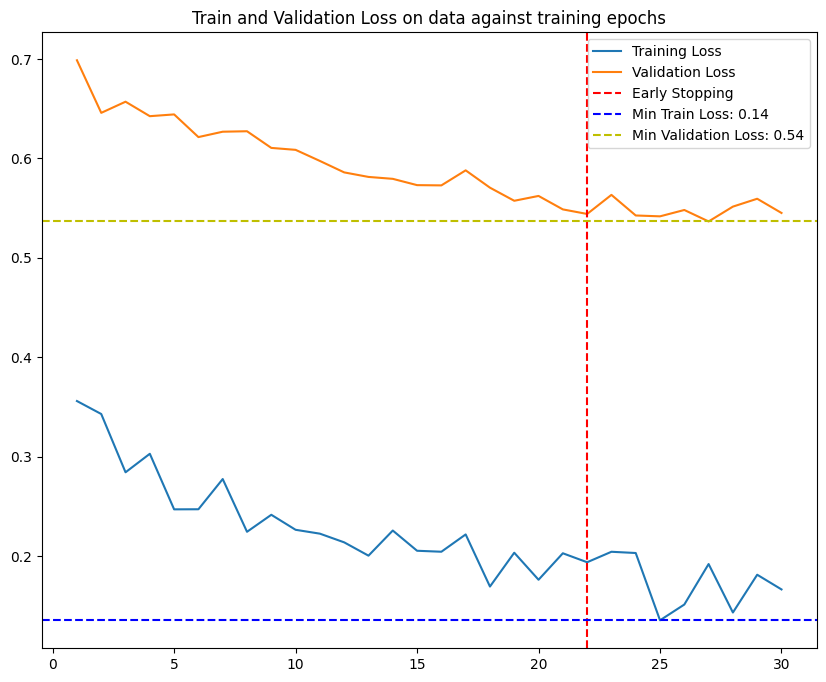

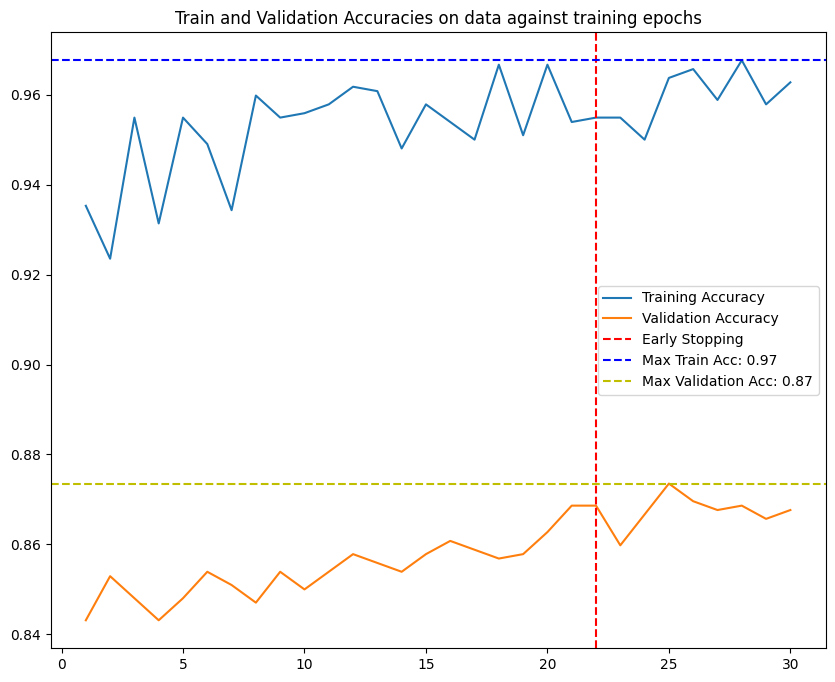

In [70]:
early_stopping_epoch = len(tr_loss)-8
min_train_loss = min(tr_loss)
min_test_loss = min(te_loss)
max_train_accuracy = max(tr_correct).cpu()
max_test_accuracy = max(te_correct).cpu()
tr_correct1 = [i.cpu() for i in tr_correct]
te_correct1 = [i.cpu() for i in te_correct]

fig = plt.figure(figsize=(10,8))
plt.title('Train and Validation Loss on data against training epochs')
plt.plot(range(1,len(tr_loss)+1),tr_loss, label='Training Loss')
plt.plot(range(1,len(te_loss)+1),te_loss,label='Validation Loss')
plt.axvline(x=early_stopping_epoch, color='r', linestyle='--', label='Early Stopping')
plt.axhline(y=min_train_loss, color='b', linestyle='--', label=f'Min Train Loss: {min_train_loss:.2f}')
plt.axhline(y=min_test_loss, color='y', linestyle='--', label=f'Min Validation Loss: {min_test_loss:.2f}')
plt.legend()
plt.show()

fig = plt.figure(figsize=(10,8))
plt.title('Train and Validation Accuracies on data against training epochs')
plt.plot(range(1,len(tr_correct1)+1),tr_correct1, label='Training Accuracy')
plt.plot(range(1,len(te_correct1)+1),te_correct1, label='Validation Accuracy')
plt.axvline(x=early_stopping_epoch, color='r', linestyle='--', label='Early Stopping')
plt.axhline(y=max_train_accuracy, color='b', linestyle='--', label=f'Max Train Acc: {max_train_accuracy:.2f}')
plt.axhline(y=max_test_accuracy, color='y', linestyle='--', label=f'Max Validation Acc: {max_test_accuracy:.2f}')
plt.legend()

In [71]:
correct = 0
total = 0
list_predicted = []
list_labels = []
with torch.no_grad():
    for data in tqdm(test_loader, desc='test'):
        images, labels = data
        images, labels = images.to(device), labels.to(device) # add this line
        outputs = model(images)

        _, predicted = torch.max(outputs.data, 1)
        predicted, labels = predicted.cpu(), labels.cpu()
        list_predicted.extend(predicted)
        list_labels.extend(labels)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print('Accuracy on test images: ', 100*(correct/total), '%')

test:   0%|          | 0/193 [00:00<?, ?it/s]

Accuracy on test images:  84.92437794763377 %


In [72]:
print(classification_report(list_labels, list_predicted))

              precision    recall  f1-score   support

           0       0.62      0.80      0.70        20
           1       1.00      0.85      0.92        40
           2       0.41      0.35      0.38        20
           3       0.49      0.56      0.52        36
           4       0.84      0.84      0.84        45
           5       0.92      0.96      0.94        25
           6       0.60      0.90      0.72        20
           7       0.96      1.00      0.98        65
           8       0.77      0.88      0.82        26
           9       0.96      0.88      0.92        25
          10       0.79      0.63      0.70        67
          11       0.97      0.87      0.91        67
          12       0.87      0.93      0.90        29
          13       0.88      1.00      0.93        28
          14       0.64      0.97      0.77        29
          15       0.91      1.00      0.95        21
          16       1.00      0.92      0.96        65
          17       0.81    

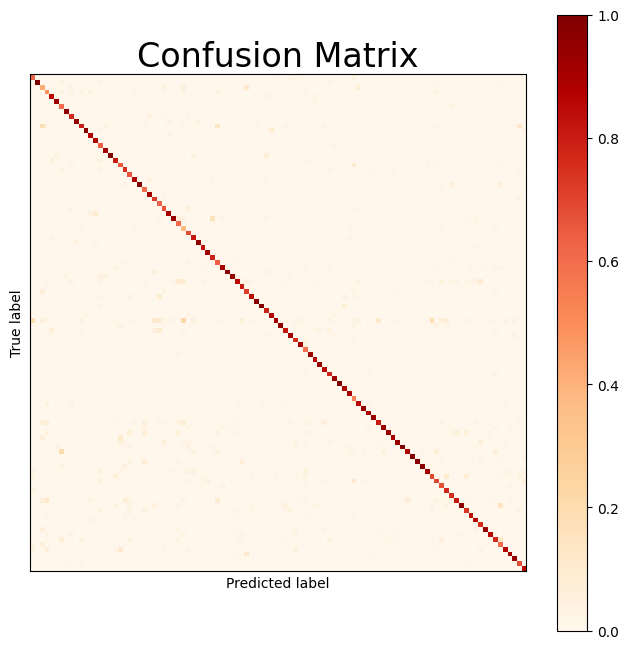

In [73]:
c_m = confusion_matrix(list_labels, list_predicted, normalize='pred')

plt.rcParams['figure.figsize'] = (8, 8)
display_c_m = ConfusionMatrixDisplay(c_m)
display_c_m.plot(cmap='OrRd', include_values=False)

plt.title('Confusion Matrix', fontsize=24)

plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
# Showing the plot
plt.show()

In [74]:
print(f"F1 Score: {f1_score(list_predicted, list_labels, average='weighted')}")

F1 Score: 0.8501672029582958


In [75]:
print(classification_report(list_labels, list_predicted))

              precision    recall  f1-score   support

           0       0.62      0.80      0.70        20
           1       1.00      0.85      0.92        40
           2       0.41      0.35      0.38        20
           3       0.49      0.56      0.52        36
           4       0.84      0.84      0.84        45
           5       0.92      0.96      0.94        25
           6       0.60      0.90      0.72        20
           7       0.96      1.00      0.98        65
           8       0.77      0.88      0.82        26
           9       0.96      0.88      0.92        25
          10       0.79      0.63      0.70        67
          11       0.97      0.87      0.91        67
          12       0.87      0.93      0.90        29
          13       0.88      1.00      0.93        28
          14       0.64      0.97      0.77        29
          15       0.91      1.00      0.95        21
          16       1.00      0.92      0.96        65
          17       0.81    